# Climate Change Forecasting

## Objective

This project is designed to project the global and regional temperature in next 50 and 100 years.

**Specifically**, the project have One main objectives:
1. Predict temperature anomalies over time and forecast in next 50 to 100 years


`SARIMA` and `Prophet` models will be used in forecasting and evaluate which one suits the data better

The results from this analysis will provide insights on how the world is performing in reducing global warming and its impacts as per [Paris Agreement](https://unfccc.int/process-and-meetings/the-paris-agreement) to limit global warming to **2°C** above pre-industrial era or at best **1.5°C**. This will limit the global warming impact across different sectors such as agriculture, economics, environmental conservation, among others.

## About the dataset

This dataset contain historical global average surface temperature estimated by combining the Berkeley Earth land-surface temperature field with a reinterpolated version of the HadSST ocean temperature field.

We will be using version that report the tempeature anomalies in the presence of sea ice extrapolated from land surface air temperature anomalies as opposed to other dataset that extrapolated sea ice from sea surface water temperature.

The reason is that the air temperature version of this average shows larger changes in the recent period, in part this is because water temperature changes are limited by the freezing point of ocean water. Berkely experts believe that the use of air temperatures above sea ice provides a more natural means of describing changes in Earth's surface temperature. 

temperature are in **celcius degree** and reported as anomalies relative to the January 1951-December 1980 average of 14.102 +/- 0.019 along with 95% Confidence Interval

You can access data from [BERKELEY EARTH Website](https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Land_and_Ocean_complete.txt)

## Data Extraction

In [15]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from prophet import Prophet
from prophet.diagnostics import cross_validation
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

print('Library is ready')

Library is ready


In [23]:
# Explore data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              2100 non-null   int64  
 1   Month             2100 non-null   int64  
 2   Anomalies         2100 non-null   float64
 3   Uncertainties     2100 non-null   float64
 4   annual_anom       2089 non-null   float64
 5   annual_uncer      2089 non-null   float64
 6   five_year_anom    2041 non-null   float64
 7   five_year_uncer   2041 non-null   float64
 8   ten_year_anom     1981 non-null   float64
 9   ten_year_uncer    1981 non-null   float64
 10  twenty_yearanom   1861 non-null   float64
 11  twenty_year_anom  1861 non-null   float64
 12  Unc."             0 non-null      float64
dtypes: float64(11), int64(2)
memory usage: 213.4 KB


In [28]:
# Import dataset
path=r"C:\Users\USER\OneDrive - University of Global Health Equity\Documents\PERSONAL DOCUMENTS\PERSONAL DEVELOPMENT\Projects Portfolio\Climate change forecasting\formatted Raw data Berkely.csv"
df=pd.read_csv(path)

# extract variable date with yyyy-mm
def make_date(row):
    return datetime(year=int(row['Year']), month=int(row['Month']), day=1)
df['date']=df.apply(make_date, axis=1)

# Treate date as index
df=df.set_index('date')

# Extract only monthly anomalies as they are the only data we need
data=df[['Anomalies']]
data.head()

,Anomalies
date,
1850-01-01,-0.753
1850-02-01,-0.202
1850-03-01,-0.367
1850-04-01,-0.596
1850-05-01,-0.619


In [29]:
# Check for index type
df.index

DatetimeIndex(['1850-01-01', '1850-02-01', '1850-03-01', '1850-04-01',
               '1850-05-01', '1850-06-01', '1850-07-01', '1850-08-01',
               '1850-09-01', '1850-10-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', name='date', length=2100, freq=None)

Now let's check for any missing month in our dataframe

In [31]:
# Check for any missing month, MS='Month start frequency'
expected=pd.date_range(start=data.index.min(), end=data.index.max(), freq= 'MS')

# compare with actual index
missing=expected.difference(data.index)

if missing.empty:
    print('No months are missing')
    
else:
    print('Missing months', missing)

No months are missing


Now, since there is no missing month, let's go on and reindex our dataframe to reflect frequency of month start

In [33]:
# Let's first sort our index to increasing order to avoid mismatch of indexes
data=data.sort_index(ascending=True)

# Now replace indexes
data_full=data.reindex(expected).interpolate(method='time')
print(data_full.index)
print(data_full.head())

DatetimeIndex(['1850-01-01', '1850-02-01', '1850-03-01', '1850-04-01',
               '1850-05-01', '1850-06-01', '1850-07-01', '1850-08-01',
               '1850-09-01', '1850-10-01',
               ...
               '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01',
               '2024-07-01', '2024-08-01', '2024-09-01', '2024-10-01',
               '2024-11-01', '2024-12-01'],
              dtype='datetime64[ns]', length=2100, freq='MS')
            Anomalies
1850-01-01     -0.753
1850-02-01     -0.202
1850-03-01     -0.367
1850-04-01     -0.596
1850-05-01     -0.619


## Exploratory Data Analysis

In [34]:
# Now let's explore descriptive statistics
data_full.describe()

,Anomalies
count,2100.000000
mean,0.008250
std,0.432058
min,-1.004000
25%,-0.295000
50%,-0.085500
75%,0.219250
max,1.548000


As we can see, our average temperature anomaly is nearly 0 (0.008250). however, there is a significant change between the coldest measurement and hotest measurement with range of **2.552**. This doesn't mean increase from predinsutrial era (1850) to the end of 2024. However, if we calculate that, we will find that there has been `2.042` increase at the end of 2024 from the start of 1850 which is not a good indicator from achieving Paris agreement objectives.

However, let's predict how situation will be like in 2050 and 20100 to evaluate how that agreement have been performing to prevent increase

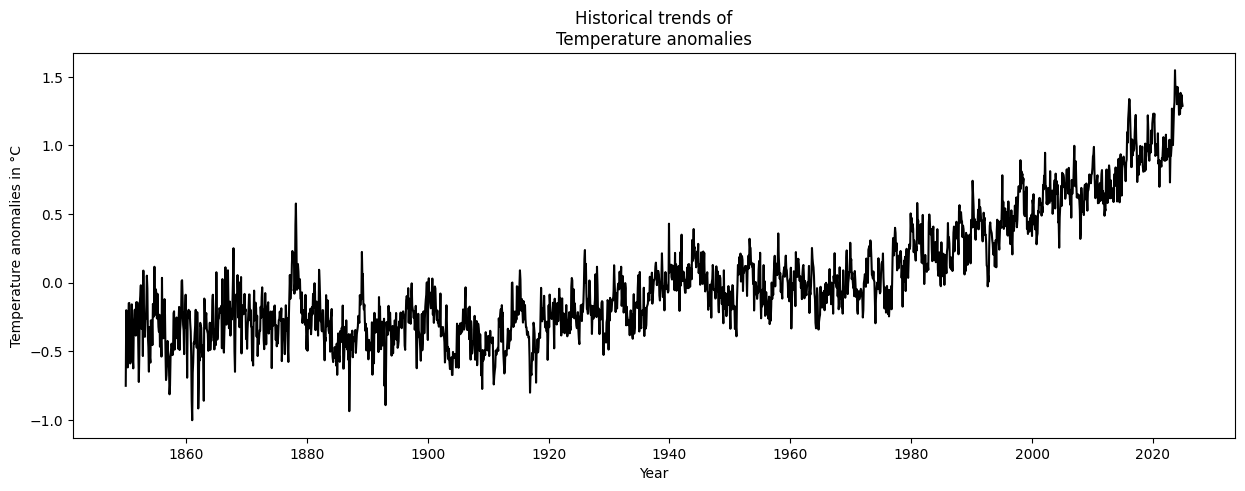

In [44]:
# Let's first visualize the trends
plt.figure(figsize=(15,5))
plt.plot(data_full, 'k-')
plt.title('Historical trends of\nTemperature anomalies')
plt.xlabel('Year')
plt.ylabel('Temperature anomalies in °C')
plt.show()

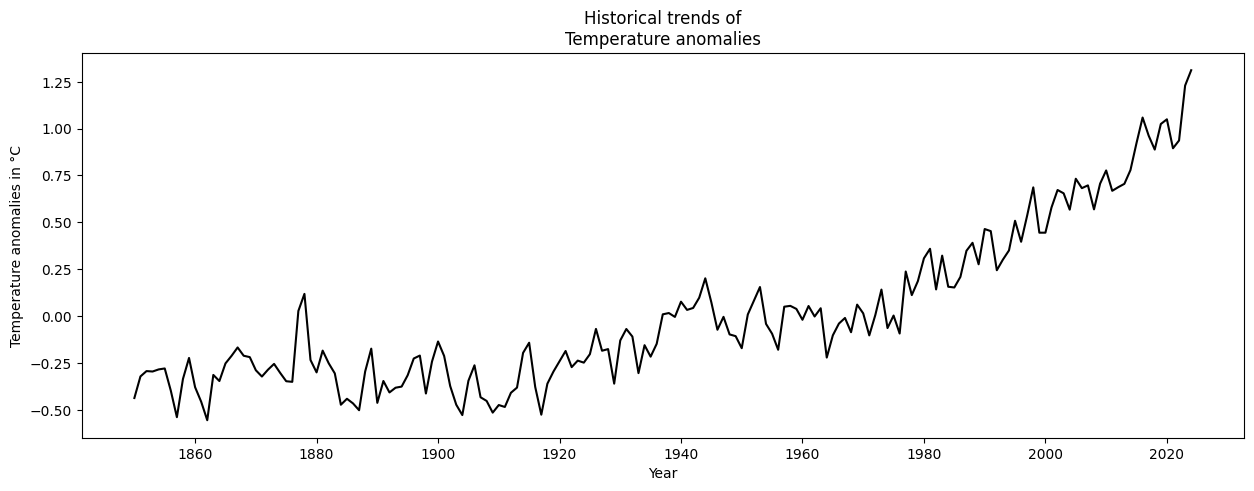

In [59]:
# let's a;so visualize anual data
data_annual=data_full.resample('YS').mean()
plt.figure(figsize=(15,5))
plt.plot(data_annual, 'k-')
plt.title('Historical trends of\nTemperature anomalies')
plt.xlabel('Year')
plt.ylabel('Temperature anomalies in °C')
plt.show()

The first observation is that there is a seasonality in our dataset.
we can also see that the temperature anomalies have experience a continous increasing trends from around 1950 to present.
There seem to be similar variations across our dataset.

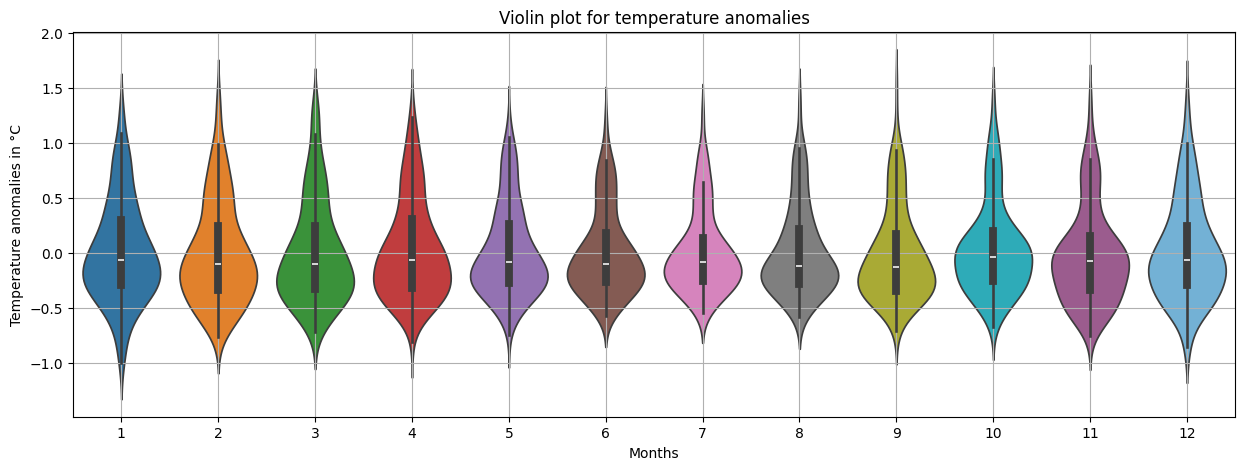

In [47]:
# Let's evaluate yearly seasonality using violin plot
plt.figure(figsize=(15,5))
palette=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b", "#e377c2","#7f7f7f","#bcbd22","#17becf","#a55194","#63b6e5"]

sns.violinplot(x=data_full.index.month, y=data_full.Anomalies, palette=palette)
plt.xlabel('Months')
plt.ylabel('Temperature anomalies in °C')
plt.title('Violin plot for temperature anomalies')
plt.grid()
plt.show()

In above chart, we can barely see any seasonality in temperature anomalies hence erasing our above statement that there is some sort of seasonality

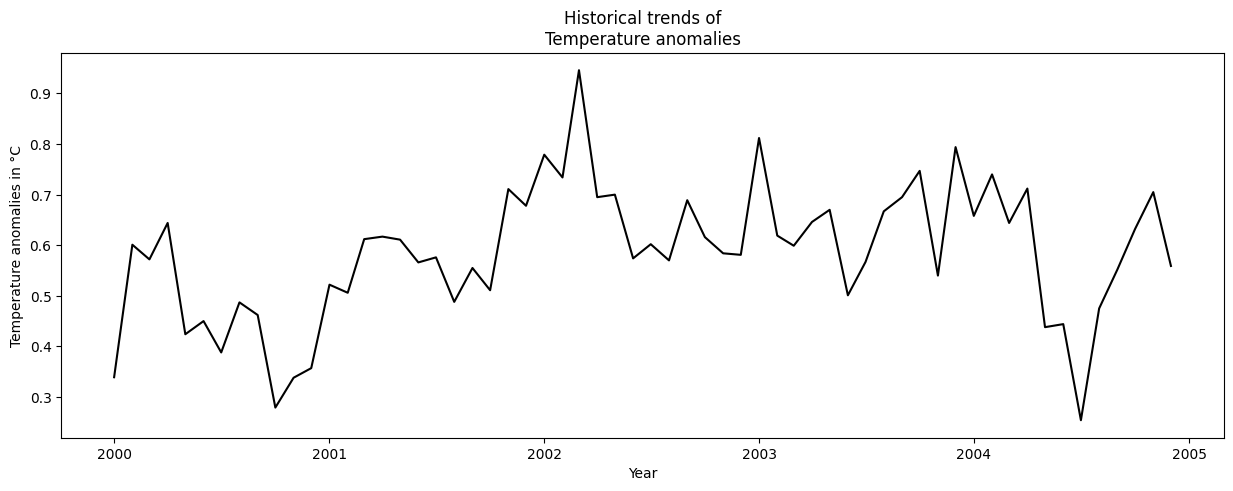

In [50]:
# Let's take a part of our data, for example from 2000 to 2004 and plot that part
datan=data_full['2000-01-01':'2004-12-01']
plt.figure(figsize=(15,5))
plt.plot(datan, 'k-')
plt.title('Historical trends of\nTemperature anomalies')
plt.xlabel('Year')
plt.ylabel('Temperature anomalies in °C')
plt.show()

As we can see, there is no seasonality

In [51]:
# Now, let's assess for similarity of mean and variance

# Let's devide our dataset into 12 chunks
chunks=np.split(data_full.Anomalies, indices_or_sections=12)
vals={'mean': np.mean(chunks, axis=1), 'variance': np.var(chunks, axis=1)}
stats=pd.DataFrame(vals)
stats

,mean,variance
0,-0.361583,0.039460
1,-0.222931,0.039631
2,-0.349703,0.029876
3,-0.326331,0.024437
4,-0.352131,0.030014
5,-0.180463,0.020320
6,0.010366,0.020169
7,-0.014783,0.019749
8,0.056960,0.029626
9,0.308326,0.024979


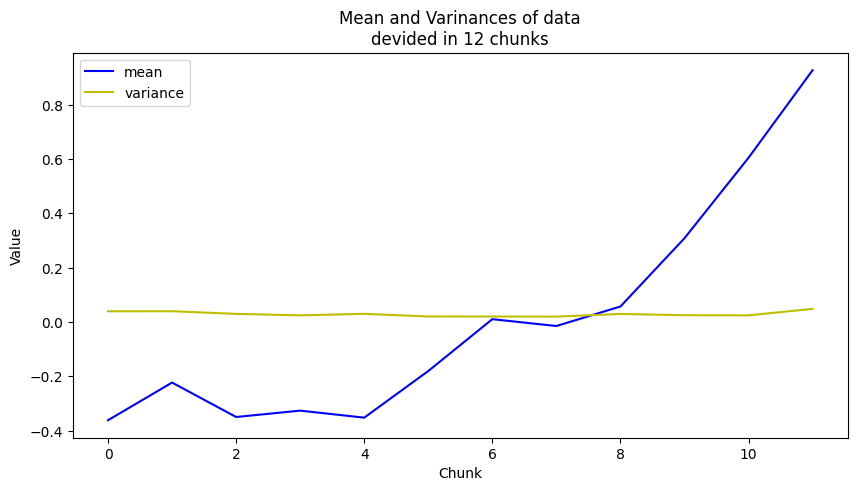

In [54]:
# Let's visualize our results
plt.figure(figsize=(10,5))
plt.plot(stats['mean'], 'b-', label='mean')
plt.plot(stats['variance'], 'y-', label='variance')
plt.legend()
plt.title('Mean and Varinances of data\ndevided in 12 chunks')
plt.xlabel('Chunk')
plt.ylabel('Value')
plt.show()

Now, we can see that while variance remains similar, average experience increase trajectory as we move forward with chunks

In [55]:
# Now let's evaluate autocorrelation as well as rolling mean and std using adfuller test

# Let's define Dickey-Fuller test (DFT) function

def dftest(timeseries, window=12):
    import statsmodels.tsa.stattools as ts
    dftest=ts.adfuller(timeseries,)
    dfoutput=pd.Series(dftest[0:4],
                      index=['Test statistics', 'p-value', 'lags used', 'observations'])
    print(f'Dickey-Fuller Test\n\n{dfoutput}')

    # Let's add rolling statistics plots to the function
    rollmean=timeseries.rolling(window).mean()
    rollstd=timeseries.rolling(window).std()

    # Plotting
    plt.figure(figsize=(15,5))
    orig=plt.plot(timeseries, 'b-', label='Original')
    mean=plt.plot(rollmean, 'r-', label='Rolling mean')
    std=plt.plot(rollstd, 'k-', label='Rolling std')
    plt.legend()
    plt.title('Rolling mean and standard deviation')
    plt.show()

Dickey-Fuller Test

Test statistics      -0.259108
p-value               0.931099
lags used            24.000000
observations       2075.000000
dtype: float64


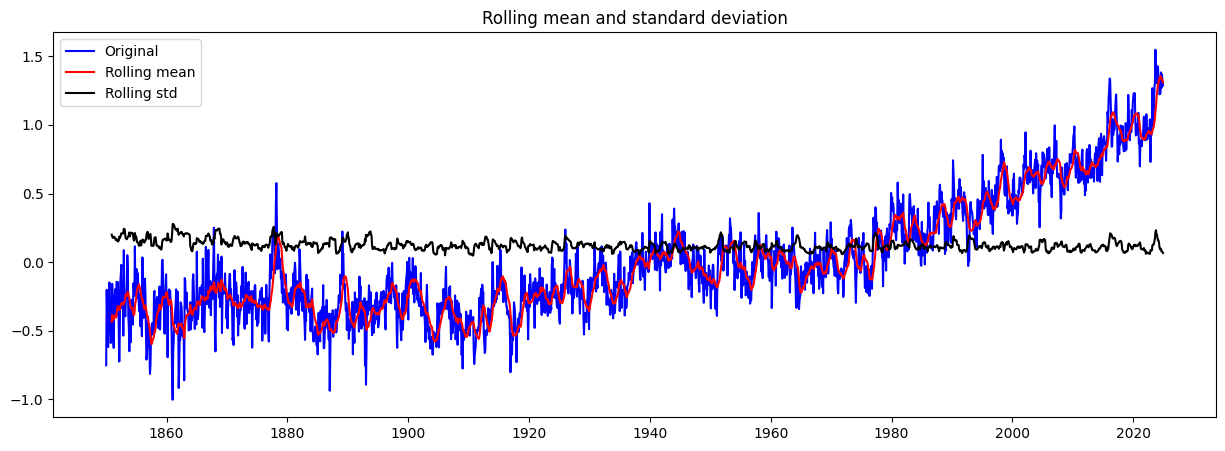

In [60]:
# Explore autocorrelation for monthly data
dftest(data_full.Anomalies, window=12)

Dickey-Fuller Test

Test statistics      2.633455
p-value              0.999081
lags used            9.000000
observations       165.000000
dtype: float64


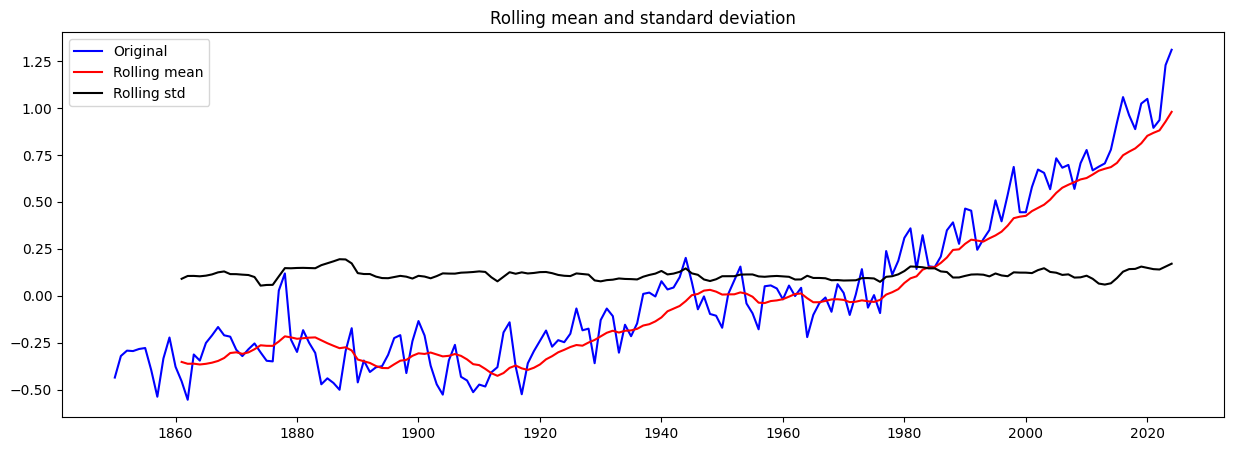

In [62]:
# Let's explore autocorrelation for yearly data
dftest(data_annual.Anomalies, window=12)

With P-value from `Dickey-Fuller test` above cutt of point of `0.05`, we can conclude that our dataset is not stationary and experience autocorrelation.

More to that, we can see that rolling standard deviation looks similar indicating **homoscedasticity** while mean looks steady from 1850 to around 1950 and start to increase until present time

Dickey-Fuller Test

Test statistics   -1.315491e+01
p-value            1.343401e-24
lags used          2.300000e+01
observations       2.075000e+03
dtype: float64


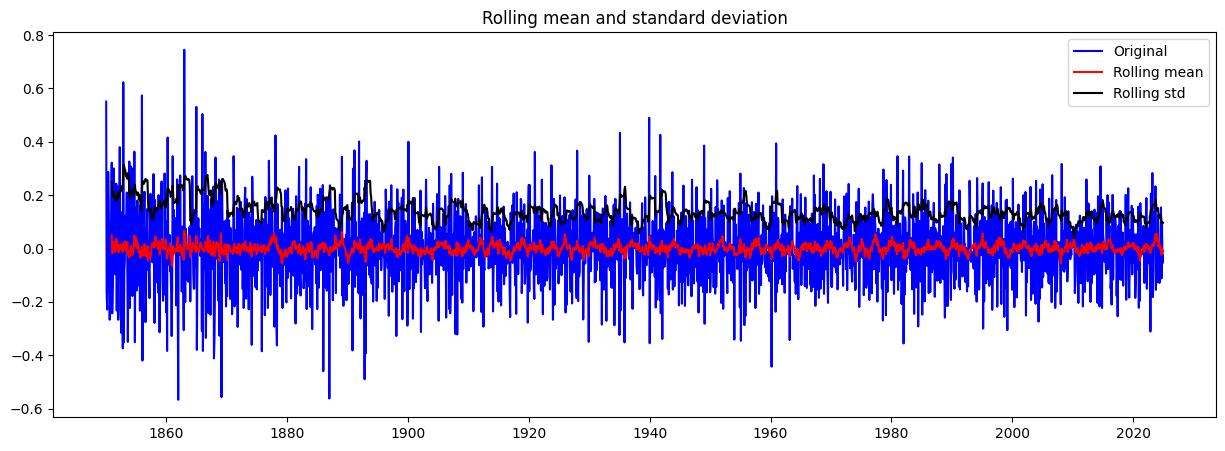

In [68]:
# let's explore if our dataset can be stationary after applying first degree difference
data_diff=data_full.diff()  # First degree difference
dftest(data_diff.Anomalies.dropna(), window=12)

**Perfect, this shows that the first degree difference makes our dataset stationary**

In [64]:
# Let's use autocorrelation and partial autocorrelation plot
# to determine p and q for SARIMA model
# first let's create a helper function
def plots(data, lags=None):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    fig, ax=plt.subplots(1,3, figsize=(20,8))
    ax[0].plot(data, 'b-')
    ax[0].set_title('Original')
    plot_acf(data, lags=lags, ax=ax[1])
    ax[1].set_title('ACF')
    plot_pacf(data, lags=lags, ax=ax[2])
    ax[2].set_title('PACF')
    plt.tight_layout()
    plt.show()

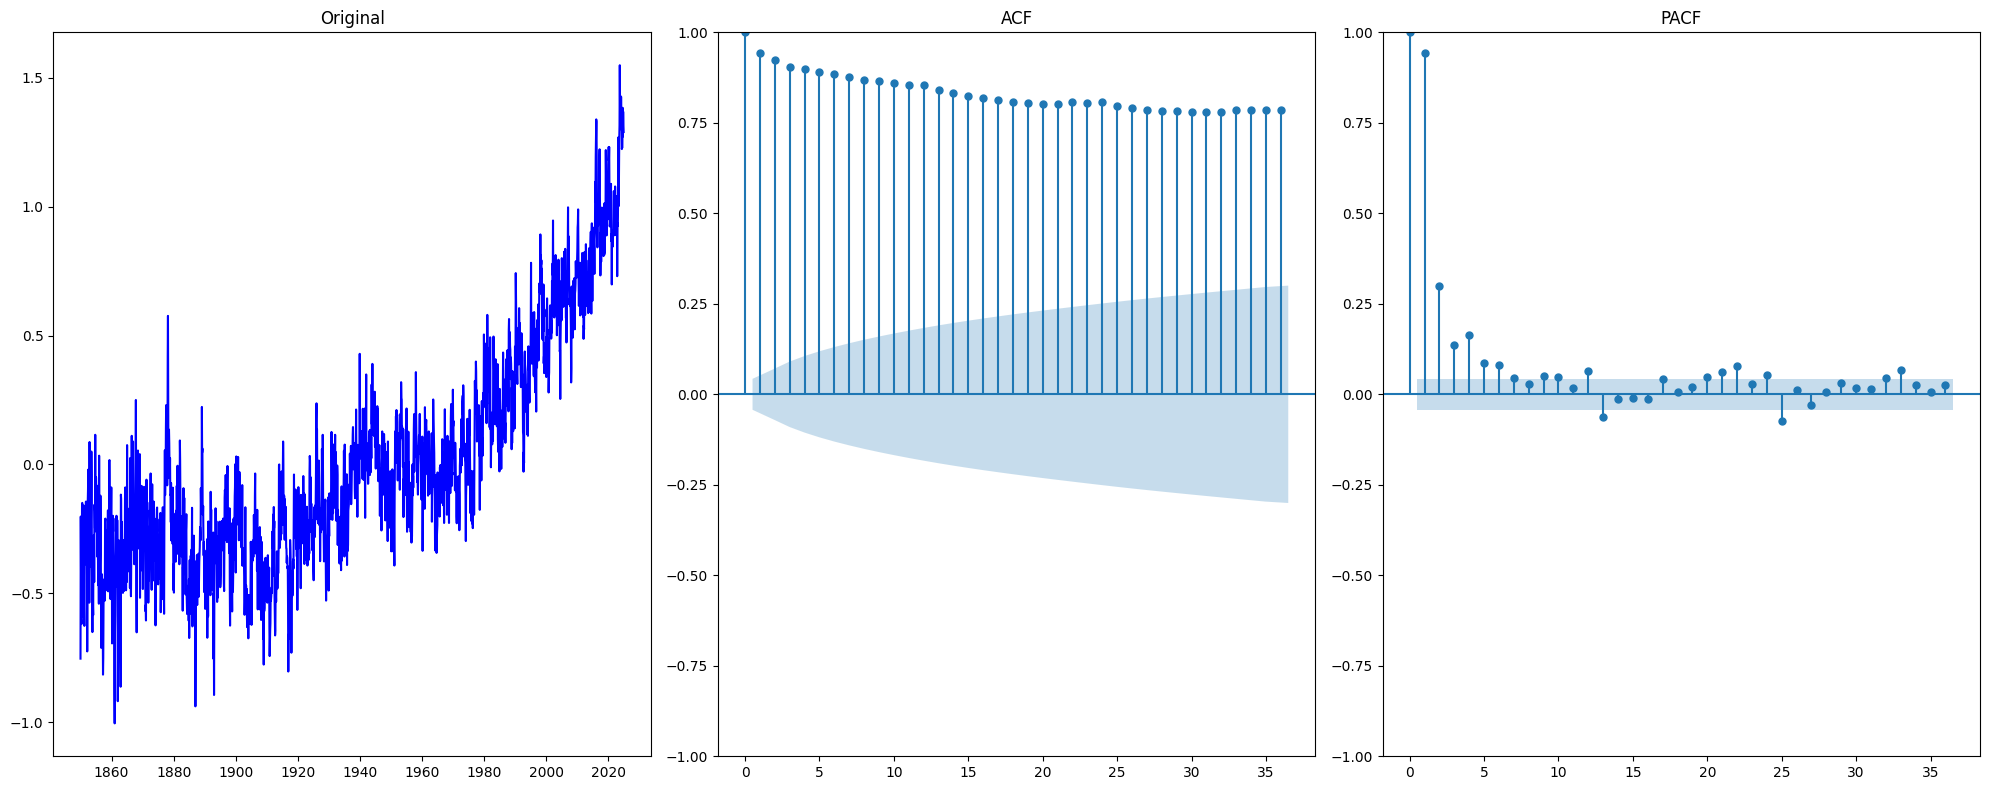

In [73]:
# Now let's check on our raw dataset
plots(data_full, lags=36)

The observations from our row dataset shows trends from original data.
**ACF** chart shows significant but diminishing spikes highlighting non stationally data with autocorrelation between previous errors
**PACF** shows significant spikes up to lag 6 indicanting possible **AR6** model

Let's explore dataset after differencing

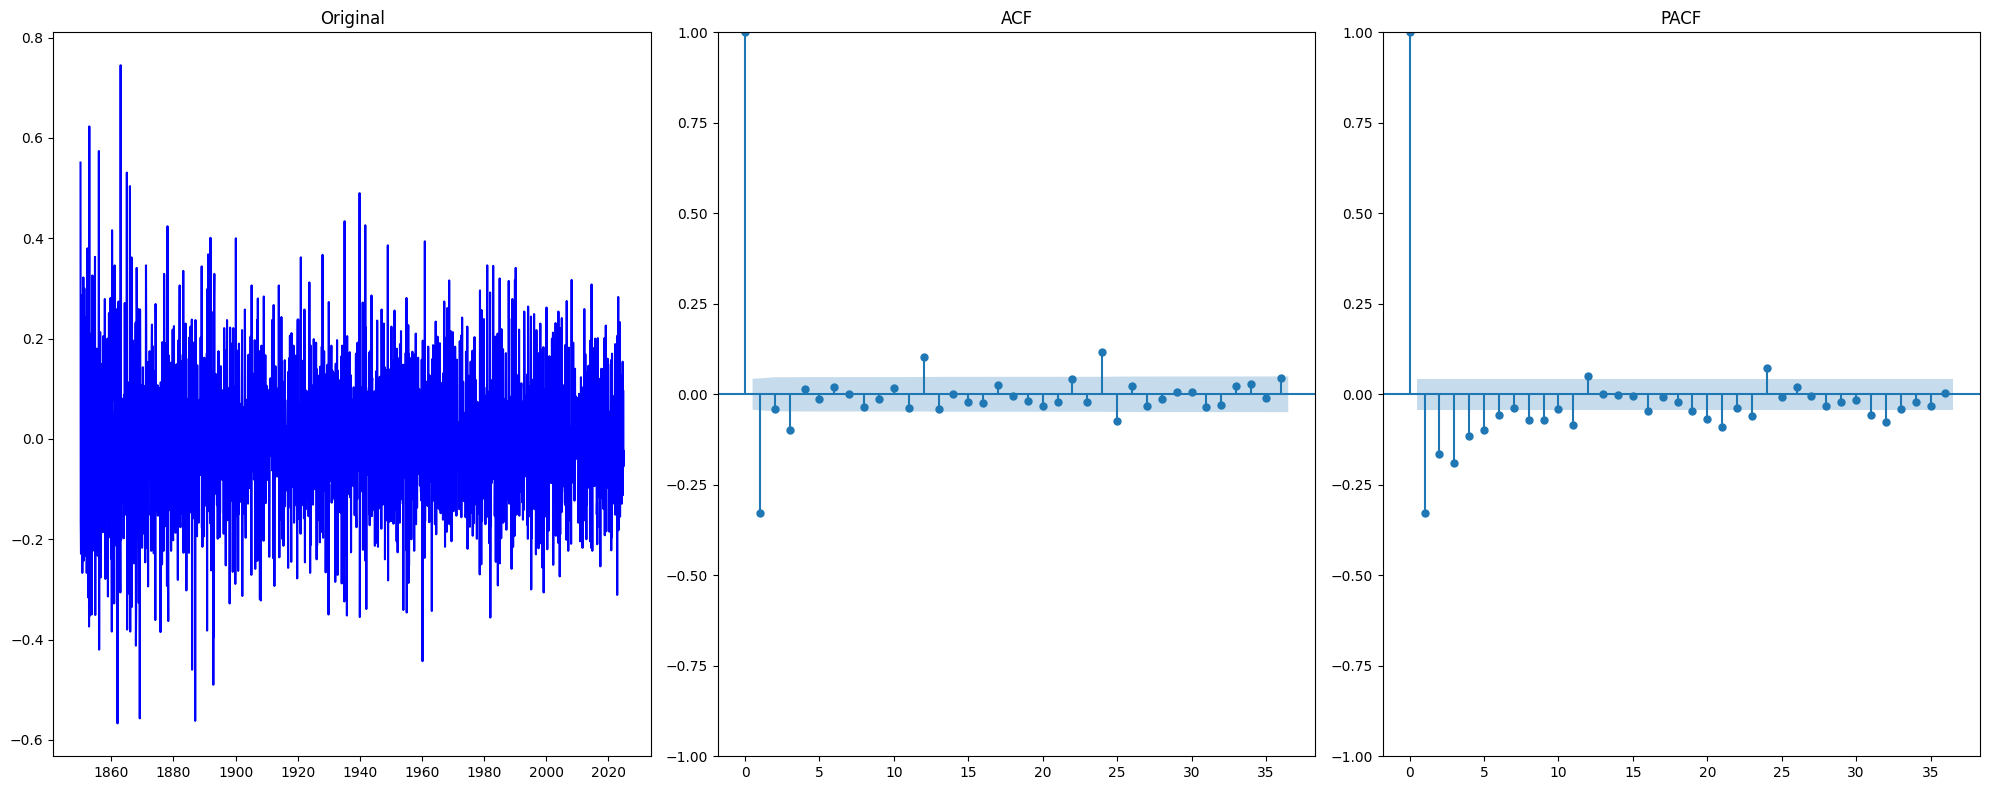

In [74]:
# Explore autocorrelation after first degree differencing
plots(data_diff.dropna(), lags=36)

### Crtitical observations from dataset
1. Data is non-stationally
2. First degree differencing makes data stationary indicating **d=1**
3. PACF plot shows possible **AR6**
4. ACF plot shows possible **MA1**

## Time series predictive modeling

Based on the above parameters, we will forecast our temperature anomalies using `ARIMA model`

In [77]:
# Let's fit SARIMAX model with p=6, q=1, d=1, no seasonality
sar1=SARIMAX(data_full.Anomalies,
           order=(6,1,1),
           seasonal_order=(0,0,0,0),
           trend='c').fit()
sar1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Anomalies   No. Observations:                 2100
Model:               SARIMAX(6, 1, 1)   Log Likelihood                1347.736
Date:                Sun, 23 Nov 2025   AIC                          -2677.473
Time:                        22:53:07   BIC                          -2626.630
Sample:                    01-01-1850   HQIC                         -2658.850
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002      0.000      0.804      0.421      -0.000       0.001
ar.L1          0.4174      0.045      9.303      0.000       0.329       0.505
ar.L2          0.0923      0.029      3.205      0.001       0.036       0.149
ar.L3         -0.0098      0.028     -0.344      0.731      -0.065       0.046
ar.L4          0.0854      0.028      3.074      0.002       0.031       0.140
ar.L5         -0.0012      0.026     -0.047      0.962      -0.053       0.050
ar.L6          0.0237      0.026      0.923      0.356      -0.027       0.074
ma.L1         -0.8980      0.041    -22.140      0.000      -0.977      -0.818
sigma2         0.0163      0.000     39.066      0.000       0.015       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                91.90
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               0.55   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Interpretation of the model

#### Model specification
- **SARIMAX(6, 1, 1)** →  
  - AR order = 6 (six autoregressive lags included)  
  - Differencing = 1 (series was differenced once to achieve stationarity)  
  - MA order = 1 (one moving average lag included)  
  - No seasonal terms are shown here, so it’s essentially an ARIMA(6,1,1).

---

#### Fit statistics
- **Log Likelihood = 1347.736** → higher is better.  
- **AIC = -2677.473, BIC = -2626.630, HQIC = -2658.850** → very negative values suggest a good fit (lower is better for AIC/BIC).  
- **No. Observations = 2100** → large sample size, which stabilizes estimates.

---

#### Coefficients
- **Intercept = 0.0002 (p=0.421)** → not statistically significant.  
- **AR terms**:
  - AR(1) = 0.4174, highly significant (p < 0.001).  
  - AR(2) = 0.0923, significant (p = 0.001).  
  - AR(3) = -0.0098, not significant (p = 0.731).  
  - AR(4) = 0.0854, significant (p = 0.002).  
  - AR(5) = -0.0012, not significant (p = 0.962).  
  - AR(6) = 0.0237, not significant (p = 0.356).  
  Interpretation: Only AR(1), AR(2), and AR(4) contribute meaningfully; others may be redundant.

- **MA(1) = -0.8980, highly significant (p < 0.001)** → strong moving average component.  
- **sigma² = 0.0163** → variance of residuals, highly significant.

---

#### Diagnostic tests
- **Ljung-Box Q (lag 1) = 0.12, Prob(Q) = 0.73** → residuals show no significant autocorrelation at lag 1 (good).  
- **Jarque-Bera = 91.90, Prob(JB) = 0.00** → residuals are not normally distributed (bad).  
- **Heteroskedasticity (H) = 0.55, Prob(H) = 0.00** → evidence of heteroskedasticity (variance not constant).  
- **Skew = 0.05, Kurtosis = 4.02** → residuals are nearly symmetric but leptokurtic (heavy tails).

---

#### Insights
1. **Model fit is strong** (negative AIC/BIC, significant AR(1), AR(2), AR(4), and MA(1)).  
2. **Residual diagnostics show issues**: non-normality and heteroskedasticity. This means forecasts may be biased in uncertainty estimates.  
3. **Simplification possible**: AR(3), AR(5), AR(6) are not significant — you could try a smaller AR order (like ARIMA(2,1,1) or ARIMA(4,1,1)) and compare AIC/BIC.  
4. **Interpretation**: The series depends heavily on its immediate past (AR(1)) and has a strong MA(1) correction.  

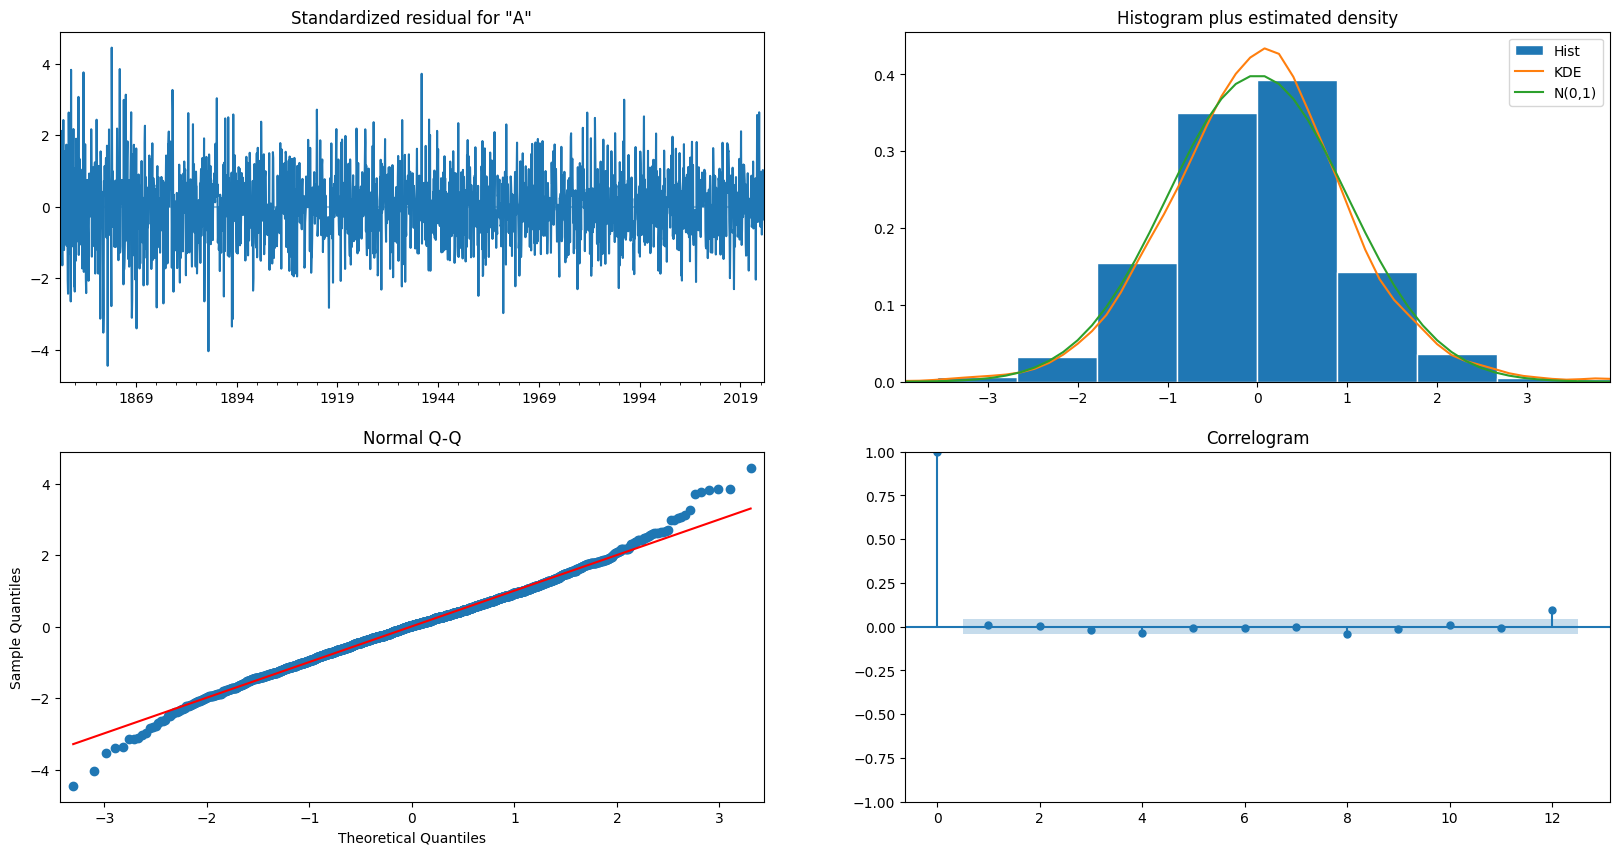

In [79]:
# The above diagnostics are evident in the folowing charts
sar1.plot_diagnostics(lags=12, figsize=(20,10));

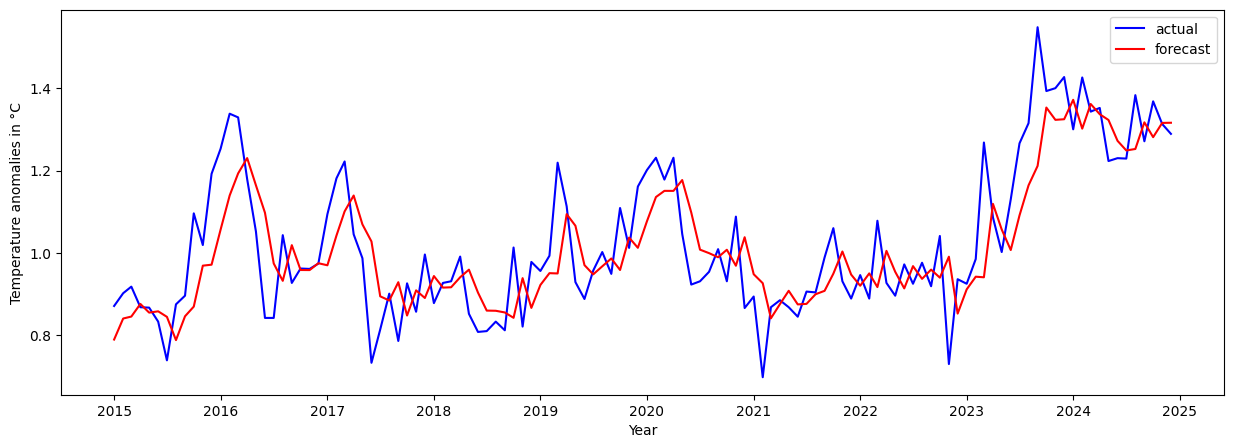

In [81]:
# Let's try making prediction for the last 10 years to check how our model is performing
data_full['forecast']=sar1.predict(start=1980, end=2100)
plt.figure(figsize=(15,5))
plt.plot(data_full.Anomalies[1980:], 'b-', label='actual')
plt.plot(data_full.forecast[1980:], 'r-', label='forecast')
plt.xlabel('Year')
plt.ylabel('Temperature anomalies in °C')
plt.legend()
plt.show()

Not very bad prediction as we can see that model managed to pick up trends and in similar range with the actual data

In [82]:
# Let's try another model but with AR4 as we saw that only lag 1, 2, 3, and 5 were significant
sar2=SARIMAX(data_full.Anomalies,
            order=(4,1,1),
            seasonal_order=(0,0,0,0),
            trend='c').fit()
sar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Anomalies   No. Observations:                 2100
Model:               SARIMAX(4, 1, 1)   Log Likelihood                1358.082
Date:                Sun, 23 Nov 2025   AIC                          -2702.164
Time:                        23:39:12   BIC                          -2662.619
Sample:                    01-01-1850   HQIC                         -2687.679
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002   8.63e-05      2.243      0.025    2.44e-05       0.000
ar.L1          0.4884      0.021     23.408      0.000       0.448       0.529
ar.L2          0.1394      0.023      6.024      0.000       0.094       0.185
ar.L3         -0.0099      0.025     -0.396      0.692      -0.059       0.039
ar.L4          0.1041      0.023      4.440      0.000       0.058       0.150
ma.L1         -0.9714      0.009   -112.175      0.000      -0.988      -0.954
sigma2         0.0161      0.000     40.268      0.000       0.015       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               117.04
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model intrepretation

#### Model Fit Statistics
- **Log Likelihood = 1358.082** → slightly higher than the previous model (1347.736).  
- **AIC = -2702.164** → lower (better) than the previous model’s AIC (-2677.473).  
- **BIC = -2662.619** → also lower than before (-2626.630).  
- **HQIC = -2687.679** → again lower than before (-2658.850).  

This means the **(4,1,1) model fits better** than the (6,1,1) model, despite using fewer parameters.

---

#### Coefficients
- **Intercept = 0.0002, p=0.025** → statistically significant, unlike in the previous model.  
- **AR terms**:
  - AR(1) = 0.4884, highly significant.  
  - AR(2) = 0.1394, significant.  
  - AR(3) = -0.0099, not significant.  
  - AR(4) = 0.1041, significant.  
So AR(1), AR(2), and AR(4) matter; AR(3) is negligible. This is cleaner than the (6,1,1) model, where AR(3), AR(5), AR(6) were all weak.  

- **MA(1) = -0.9714, extremely significant** → confirms a strong moving average component.  
- **sigma² = 0.0161** → residual variance, similar to the previous model (0.0163).

---

#### Diagnostics
- **Ljung-Box Q (lag 1) = 0.00, Prob(Q) = 0.96** → residuals show no autocorrelation (excellent).  
- **Jarque-Bera = 117.04, Prob(JB) = 0.00** → residuals are not normally distributed (same issue as before).  
- **Heteroskedasticity (H) = 0.54, Prob(H) = 0.00** → variance instability remains (same as before).  
- **Skew = 0.06, Kurtosis = 4.15** → residuals nearly symmetric but heavy-tailed (similar to previous).

---

#### Insights
1. **Model comparison**:  
   - The SARIMAX(4,1,1) is **better than SARIMAX(6,1,1)** — lower AIC/BIC, fewer insignificant AR terms.  
   - It achieves parsimony: fewer parameters, better fit.

2. **Interpretation**:  
   - The series depends strongly on its immediate past (AR(1)), moderately on AR(2) and AR(4).  
   - The MA(1) term is dominant, correcting shocks very effectively.  
   - AR(3) is not useful, and higher AR terms (5,6) from the previous model were unnecessary.

3. **Diagnostics**:  
   - Both models suffer from **non-normal residuals and heteroskedasticity**. Forecasts are fine, but confidence intervals may be unreliable.  

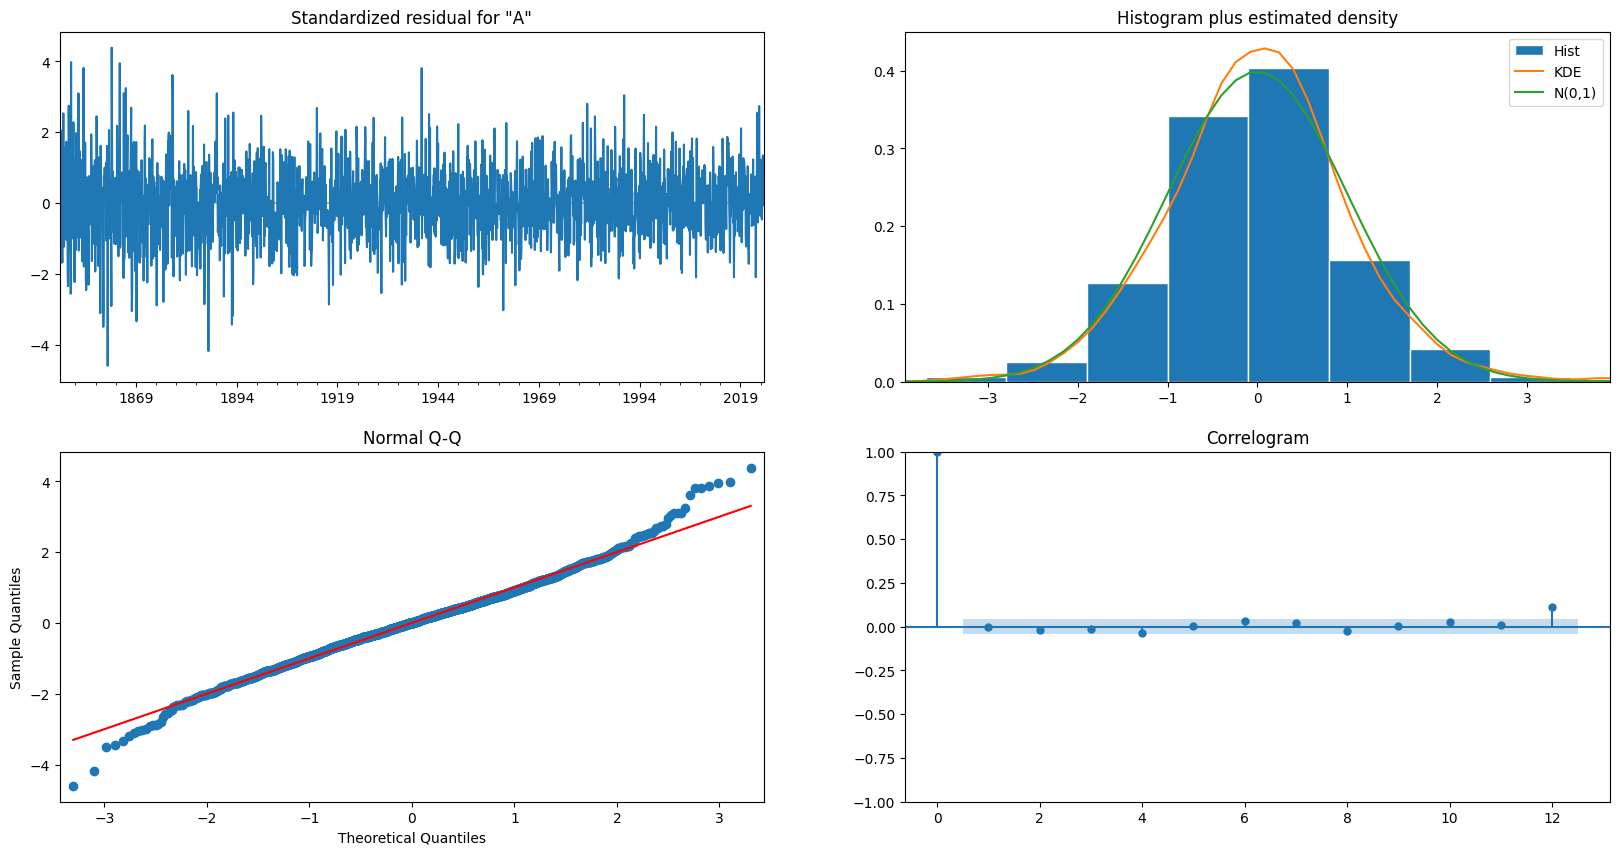

In [83]:
# Let's use visual interpretation
sar2.plot_diagnostics(lags=12, figsize=(20,10));

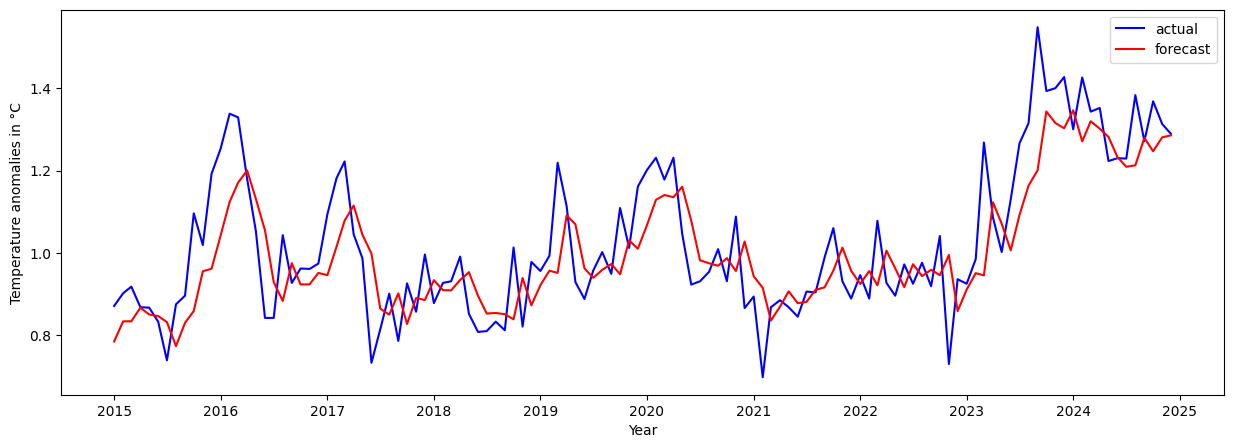

In [84]:
# Let's try prediction for the last 10 years too
data_full['forecast']=sar2.predict(start=1980, end=2100)
plt.figure(figsize=(15,5))
plt.plot(data_full.Anomalies[1980:], 'b-', label='actual')
plt.plot(data_full.forecast[1980:], 'r-', label='forecast')
plt.xlabel('Year')
plt.ylabel('Temperature anomalies in °C')
plt.legend()
plt.show()

This prediction looks also very good in picking trends and patterns

Now let's try auto arima and see what parameters best suites our dataset

In [87]:
stepwise_model=auto_arima(data_full.Anomalies,
                         start_p=1, max_p=4,
                         q=1,
                         d=1, P=0, D=0, m=0, Q=0,
                         seasonal=False,
                         trace=True,
                         stepwise=True)

print(f'Best model AIC: {stepwise_model.aic()}')

Performing stepwise search to minimize aic
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-2692.927, Time=5.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2222.295, Time=0.83 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2459.336, Time=0.98 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2590.887, Time=1.00 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2224.197, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-2645.496, Time=2.22 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2671.824, Time=2.38 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-2681.282, Time=6.25 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-2690.141, Time=6.56 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-2677.165, Time=3.96 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=7.42 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-2688.208, Time=6.93 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-2688.975, Time=1.70 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total fit time: 46.454 seconds
Best model AIC

In [86]:
# Let's fit the model using above parameters and compare with previous one
sar3=SARIMAX(data_full.Anomalies,
            order=(1,1,2),
            seasonal_order=(0,0,0,0),
            trend='c').fit()
sar3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Anomalies   No. Observations:                 2100
Model:               SARIMAX(1, 1, 2)   Log Likelihood                1351.463
Date:                Mon, 24 Nov 2025   AIC                          -2692.927
Time:                        00:01:18   BIC                          -2664.681
Sample:                    01-01-1850   HQIC                         -2682.581
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0002   6.32e-05      2.388      0.017    2.71e-05       0.000
ar.L1          0.7901      0.028     28.238      0.000       0.735       0.845
ma.L1         -1.2882      0.036    -35.940      0.000      -1.358      -1.218
ma.L2          0.3086      0.032      9.560      0.000       0.245       0.372
sigma2         0.0162      0.000     40.036      0.000       0.015       0.017
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):               107.66
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.11
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model intrepretation

#### Model Fit Statistics
- **Log Likelihood = 1351.463**  
- **AIC = -2692.927**  
- **BIC = -2664.681**  
- **HQIC = -2682.581**  

Compared to the SARIMAX(4,1,1):  
- (4,1,1) had **Log Likelihood = 1358.082, AIC = -2702.164, BIC = -2662.619**.  
- So (4,1,1) has a slightly better fit (higher log likelihood, lower AIC).  
- But (1,1,2) is more **parsimonious** (fewer parameters), which can be attractive if interpretability and simplicity matter.

---

#### Coefficients
- **Intercept = 0.0002, p=0.017** → statistically significant.  
- **AR(1) = 0.7901, highly significant** → strong autoregressive dependence on the immediate past.  
- **MA(1) = -1.2882, highly significant** → strong moving average correction.  
- **MA(2) = 0.3086, highly significant** → additional moving average component.  
- **sigma² = 0.0162** → residual variance, very similar to the (4,1,1) model (0.0161).  

Interpretation: This model is dominated by a **strong AR(1)** and **two MA terms**, which together capture short-term dynamics very effectively. It’s a compact ARIMA structure.

---

#### Diagnostics
- **Ljung-Box Q (lag 1) = 0.54, Prob(Q) = 0.46** → residuals show no autocorrelation (good).  
- **Jarque-Bera = 107.66, Prob(JB) = 0.00** → residuals are not normally distributed (same issue as before).  
- **Heteroskedasticity (H) = 0.54, Prob(H) = 0.00** → variance instability remains (same as before).  
- **Skew = 0.04, Kurtosis = 4.11** → residuals nearly symmetric but heavy-tailed (same pattern as (4,1,1)).

---

#### Insights
1. **Model comparison**:  
   - SARIMAX(4,1,1) fits slightly better (lower AIC, higher log likelihood).  
   - SARIMAX(1,1,2) is simpler, with fewer parameters, and still performs well.  
   - Both models capture strong short-term dependence, but in different ways:  
     - (4,1,1): multiple AR terms (lags 1,2,4) + MA(1).  
     - (1,1,2): one strong AR(1) + two MA terms.  

2. **Interpretation**:  
   - (1,1,2) suggests the series is best explained by **immediate autoregression plus two layers of shock correction**.  
   - (4,1,1) suggests the series depends on AR lags 1,2,4 plus one MA correction.

---

3. **Diagnostics**:  
   - Both models suffer from non-normal residuals and heteroskedasticity.  
   - Forecasts are fine, but confidence intervals may be unreliable.  


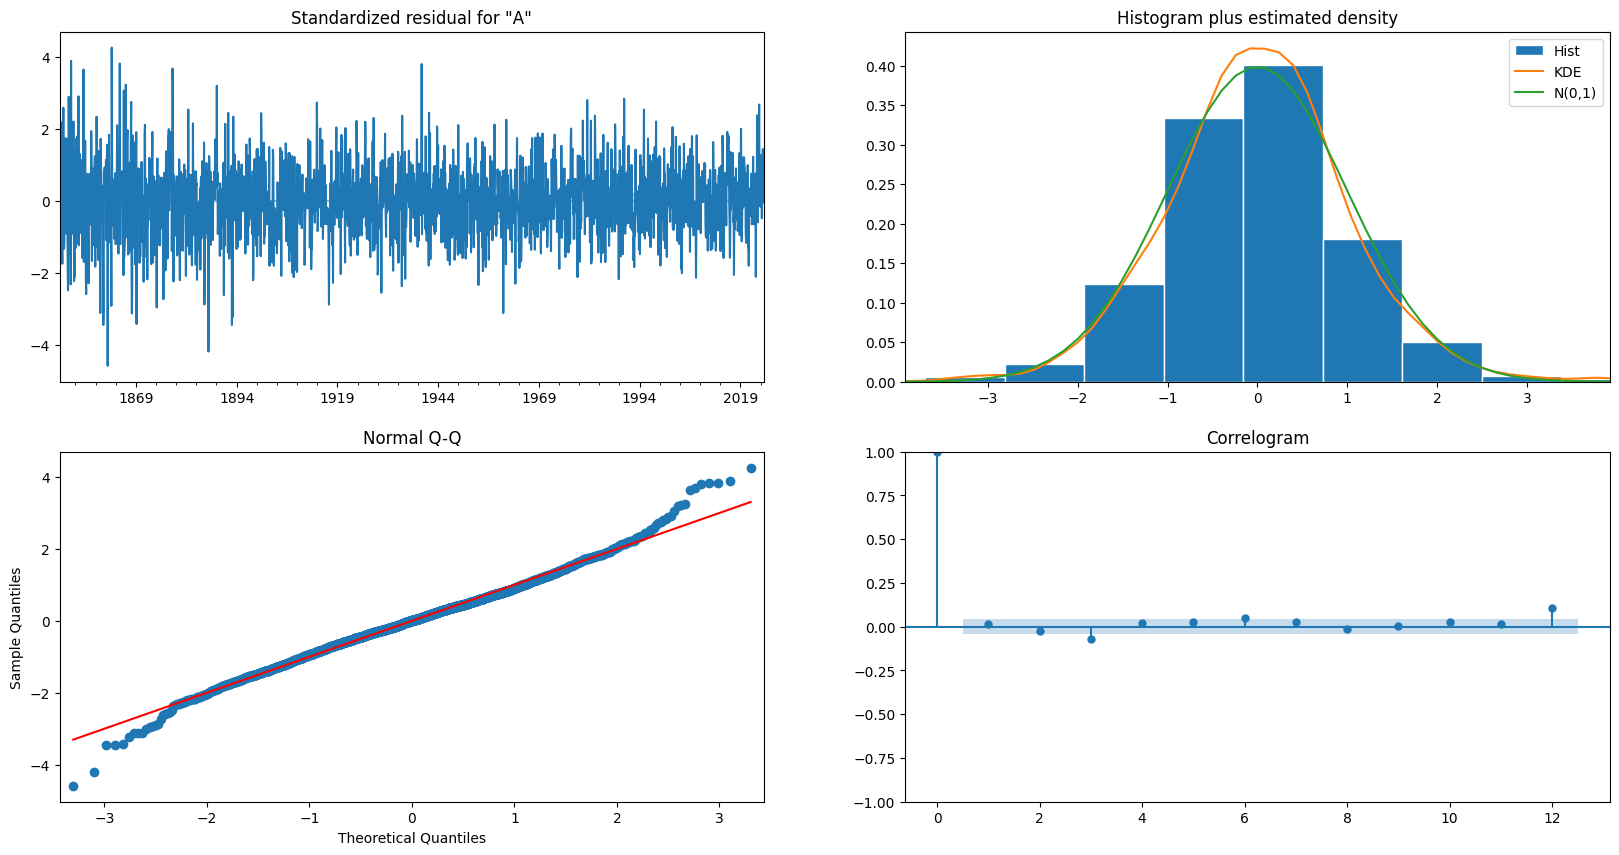

In [88]:
# We can visualize above explaination
sar3.plot_diagnostics(lags=12, figsize=(20,10));

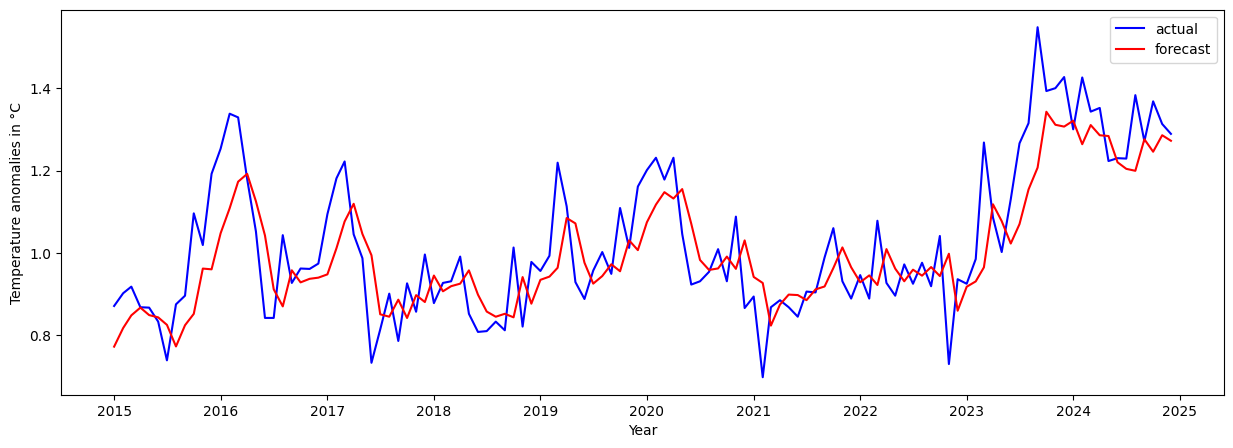

In [89]:
# Let's also do forecasting in previous 10 years
# Let's try prediction for the last 10 years too
data_full['forecast']=sar3.predict(start=1980, end=2100)
plt.figure(figsize=(15,5))
plt.plot(data_full.Anomalies[1980:], 'b-', label='actual')
plt.plot(data_full.forecast[1980:], 'r-', label='forecast')
plt.xlabel('Year')
plt.ylabel('Temperature anomalies in °C')
plt.legend()
plt.show()

## Next 25 and 75 years forecasting with confidence

Since we have identified best parameters for our model to be p=4, q=1, and d=1 for ARIMA, we can forecast what temperature anomalies will be like in 2050 and 20100 according to our objectives

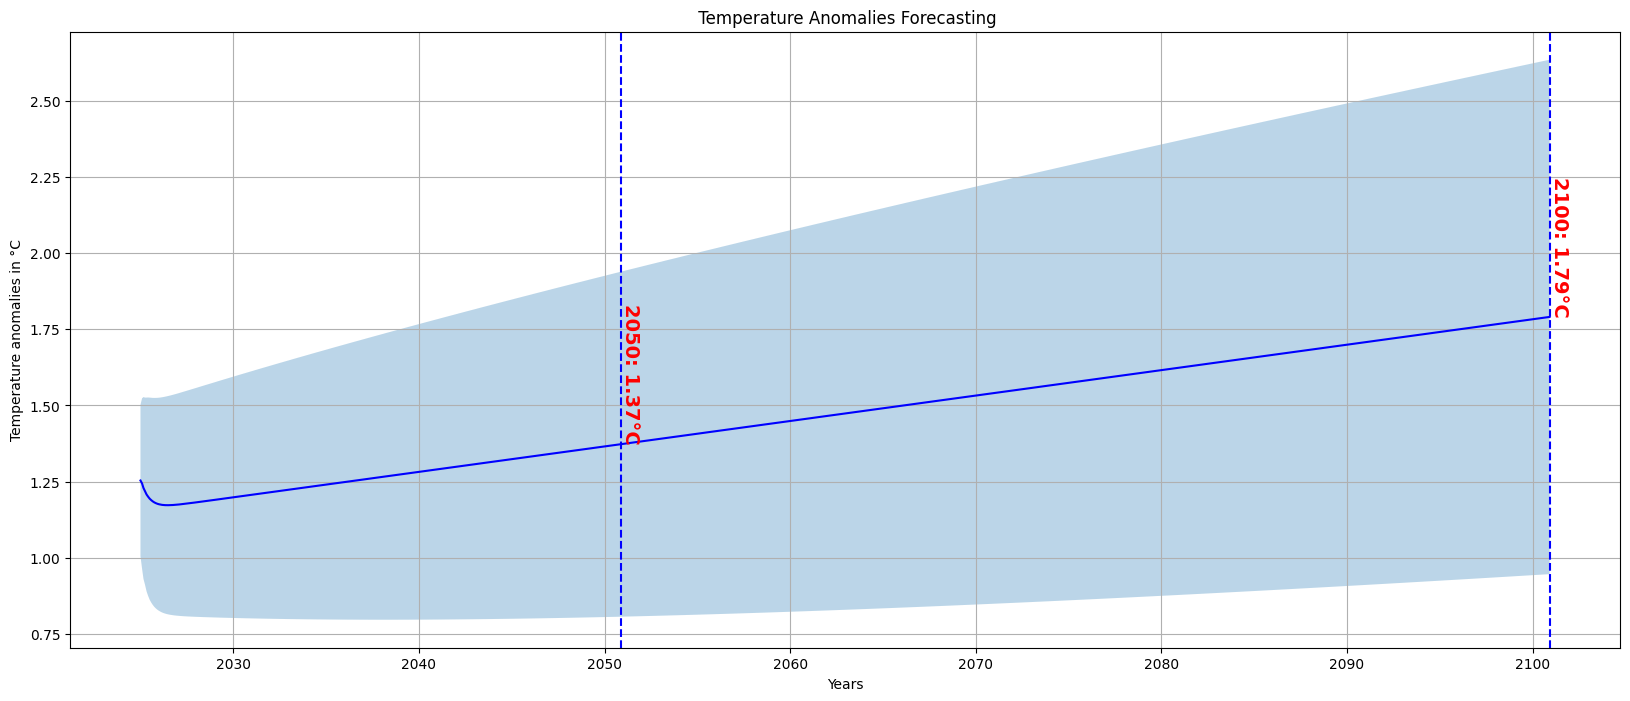

In [141]:
# Predicting next 100 years (1200 months)
model=SARIMAX(data_full.Anomalies,
                  order=(4,1,1),
                  seasonal_order=(0,0,0,0),
                  trend='c').fit()

def future_preds_df(model, series, num_months):
    from dateutil.relativedelta import relativedelta
    import pandas as pd
    
    # Create future date index
    pred_first = series.index.max() + relativedelta(months=1)
    pred_last = series.index.max() + relativedelta(months=num_months)
    date_range_index = pd.date_range(pred_first, pred_last, freq='MS')
    
    # Get forecast and confidence intervals
    forecast = model.get_forecast(steps=num_months)
    CI = forecast.conf_int(alpha=0.05)
    
    return pd.DataFrame({
        'forecast': forecast.predicted_mean.values,
        'lower_CI': CI.iloc[:,0].values,
        'upper_CI': CI.iloc[:,1].values
    }, index=date_range_index)

# Predictions
prediction1=future_preds_df(model=model, series=data_full.Anomalies, num_months=912)

# Plot predictions
plt.figure(figsize=(20,8))
plt.plot(prediction1.forecast, 'b-', label='forecast')
plt.fill_between(prediction1.index, prediction1.lower_CI, prediction1.upper_CI, alpha=0.3)

# Add vertical line indicating value for 2050 and 2100

val_2050 = prediction1.loc["2050-12-01"]
val_2100 = prediction1.loc["2100-12-01"]

# If they are Series, take the first element
val_2050 = float(val_2050.values[0]) if hasattr(val_2050, "values") else float(val_2050)
val_2100 = float(val_2100.values[0]) if hasattr(val_2100, "values") else float(val_2100)

plt.axvline(pd.to_datetime("2050-12-01"), color='blue', linestyle='--', label='2050')
plt.axvline(pd.to_datetime("2100-12-01"), color='blue', linestyle='--', label='2100')

plt.text(pd.to_datetime("2050-12-01"), val_2050,
         f"2050: {val_2050:.2f}°C",
         rotation=270, va='bottom', ha='left', color='red', fontsize=14, fontweight='bold')

plt.text(pd.to_datetime("2100-12-01"), val_2100,
         f"2100: {val_2100:.2f}°C",
         rotation=270, va='bottom', ha='left', color='red', fontsize=14, fontweight='bold')

plt.xlabel('Years')
plt.ylabel('Temperature anomalies in °C')
plt.title(' Temperature Anomalies Forecasting')
plt.xticks
plt.grid()
plt.show()

In [140]:
data_annual.head()

,Anomalies
1850-01-01,-0.435667
1851-01-01,-0.320750
1852-01-01,-0.292250
1853-01-01,-0.294500
1854-01-01,-0.283333


In [145]:
# Forecast resampled in years
prediction1_annual=prediction1.resample('YS').mean()
print(f'In 2050, temp: {prediction1_annual.loc["2050-01-01"]}\n')
print(f'In 2100, temp: {prediction1_annual.loc["2100-01-01"]}\n')
print(f'In 2025, temp: {prediction1_annual.loc["2025-01-01"]}')

In 2050, temp: forecast    1.369402
lower_CI    0.806068
upper_CI    1.932735
Name: 2050-01-01 00:00:00, dtype: float64

In 2100, temp: forecast    1.786947
lower_CI    0.944657
upper_CI    2.629237
Name: 2100-01-01 00:00:00, dtype: float64

In 2025, temp: forecast    1.204996
lower_CI    0.886399
upper_CI    1.523593
Name: 2025-01-01 00:00:00, dtype: float64


The Above prediction indicates that:
* **In 2050**, temperature will rise up to **1.81 °C +/- 1.13** when compared to 1850, the beginning of industrial era
* **In 2100**, temperature will rise up to **2.22 °C +/- 1.69** when compared to 1850, the beginning of industrial era

# Other scenario

Would the performance of model improve `(residual are homoscedastistic and normally distributed)` if we consider historical data from 1950 **When we started experiencing upward trends in temperature anomalies**?

In [106]:
# Preparind dataset
data=data_full['1950-01-01':]
data=data[['Anomalies']]
data.head()

,Anomalies
1950-01-01,-0.225
1950-02-01,-0.337
1950-03-01,-0.113
1950-04-01,-0.200
1950-05-01,-0.069


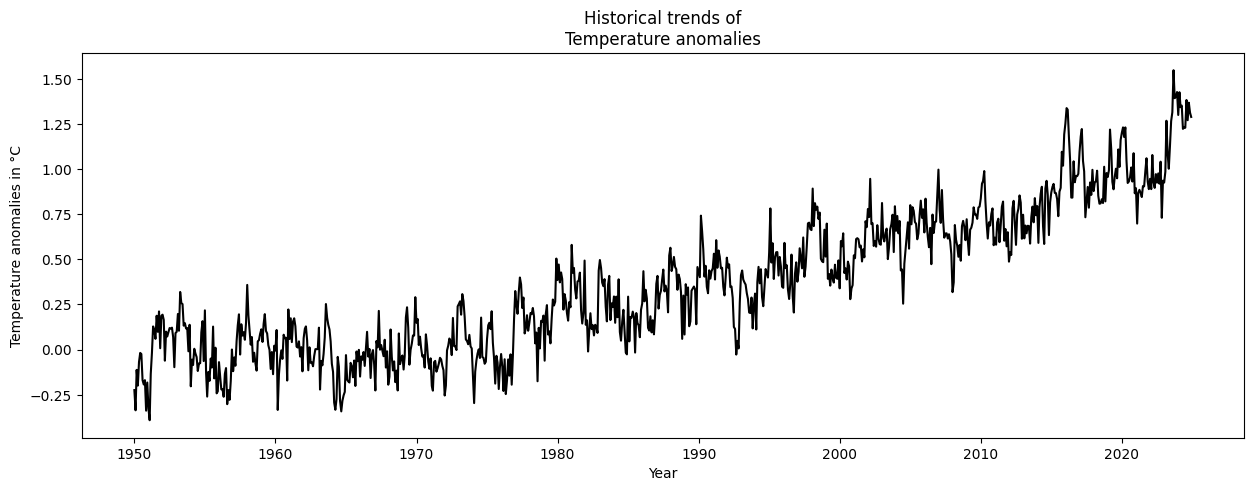

In [107]:
# Let's visualize our dataset (monthly data)
plt.figure(figsize=(15,5))
plt.plot(data, 'k-')
plt.title('Historical trends of\nTemperature anomalies')
plt.xlabel('Year')
plt.ylabel('Temperature anomalies in °C')
plt.show()

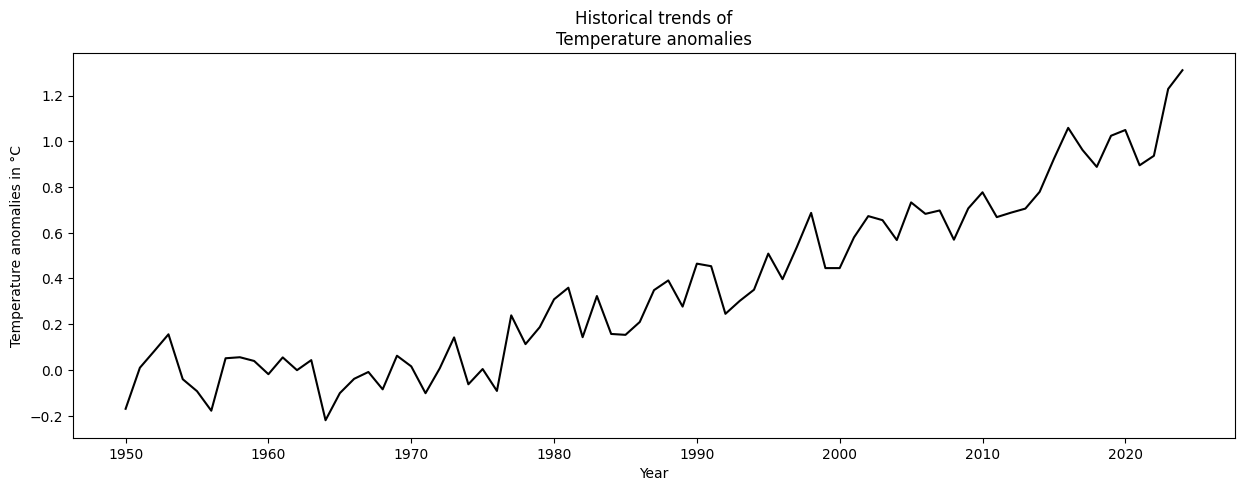

In [108]:
# Let's visualize yearly average
data_yearly=data.resample('YS').mean()
plt.figure(figsize=(15,5))
plt.plot(data_yearly, 'k-')
plt.title('Historical trends of\nTemperature anomalies')
plt.xlabel('Year')
plt.ylabel('Temperature anomalies in °C')
plt.show()

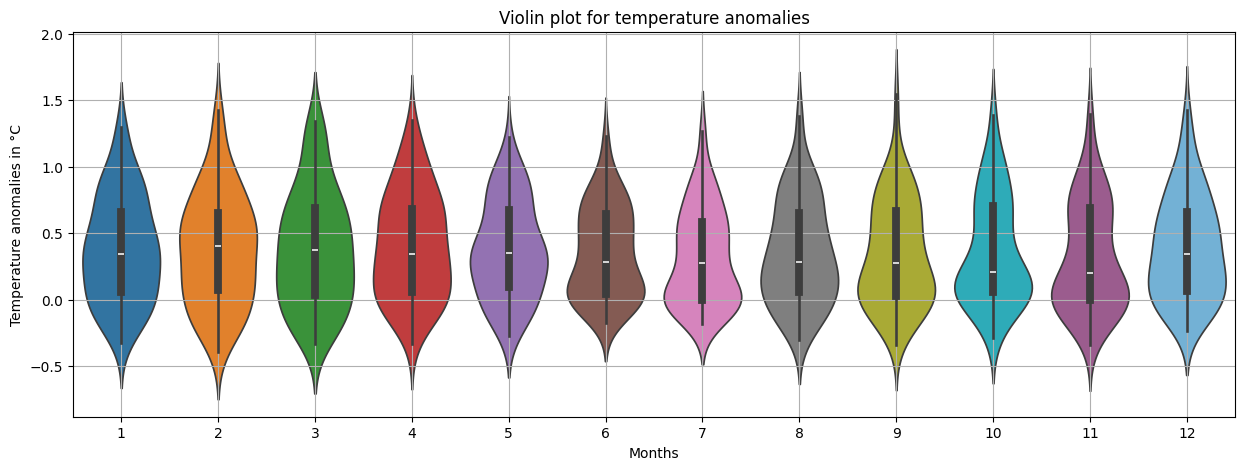

In [110]:
# Let's check for monthly seasonality
# Let's evaluate yearly seasonality using violin plot
# No seasonality
plt.figure(figsize=(15,5))
palette=["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd","#8c564b", "#e377c2","#7f7f7f","#bcbd22","#17becf","#a55194","#63b6e5"]

sns.violinplot(x=data.index.month, y=data.Anomalies, palette=palette)
plt.xlabel('Months')
plt.ylabel('Temperature anomalies in °C')
plt.title('Violin plot for temperature anomalies')
plt.grid()
plt.show()

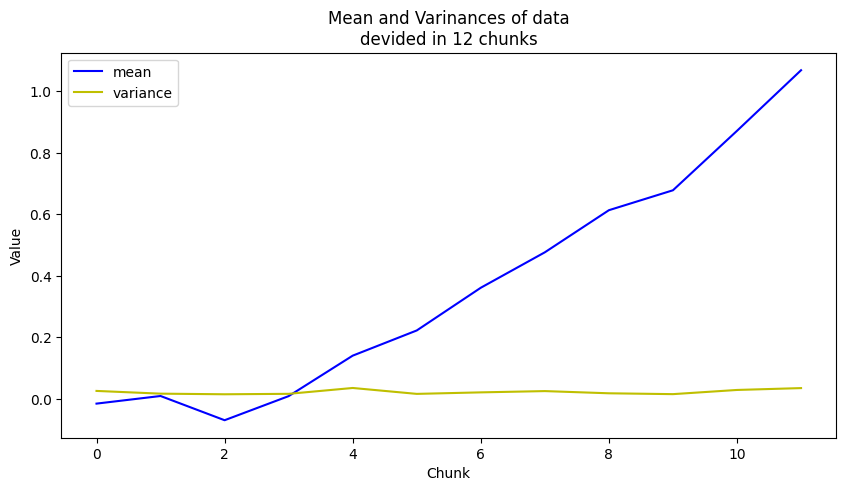

In [111]:
# Now, let's assess and visualize similarity of mean and variance

# Let's devide our dataset into 12 chunks
chunks=np.split(data.Anomalies, indices_or_sections=12)
vals={'mean': np.mean(chunks, axis=1), 'variance': np.var(chunks, axis=1)}
stats=pd.DataFrame(vals)

# Let's visualize our results
plt.figure(figsize=(10,5))
plt.plot(stats['mean'], 'b-', label='mean')
plt.plot(stats['variance'], 'y-', label='variance')
plt.legend()
plt.title('Mean and Varinances of data\ndevided in 12 chunks')
plt.xlabel('Chunk')
plt.ylabel('Value')
plt.show()



Variance looks similar but average have upward trends

Dickey-Fuller Test

Test statistics     -1.062980
p-value              0.729607
lags used           10.000000
observations       889.000000
dtype: float64


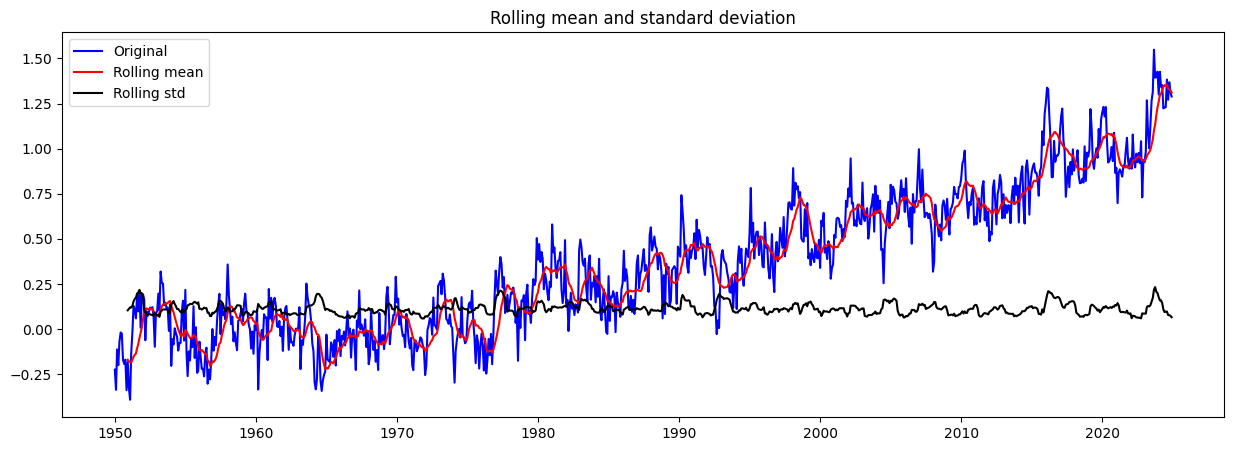

In [113]:
# Let's assess dickey-fuller test
dftest(data.Anomalies, window=12)

Dickey-Fuller Test

Test statistics     1.856565
p-value             0.998455
lags used          10.000000
observations       64.000000
dtype: float64


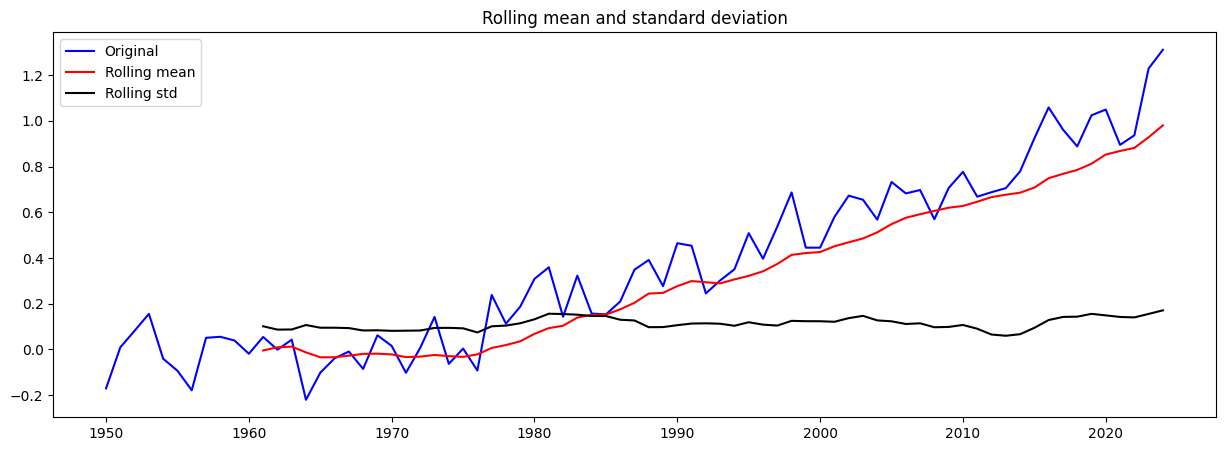

In [114]:
# How about yearly data
dftest(data_yearly.Anomalies, window=12)

Dickey-Fuller Test

Test statistics   -9.898057e+00
p-value            3.415827e-17
lags used          2.100000e+01
observations       8.770000e+02
dtype: float64


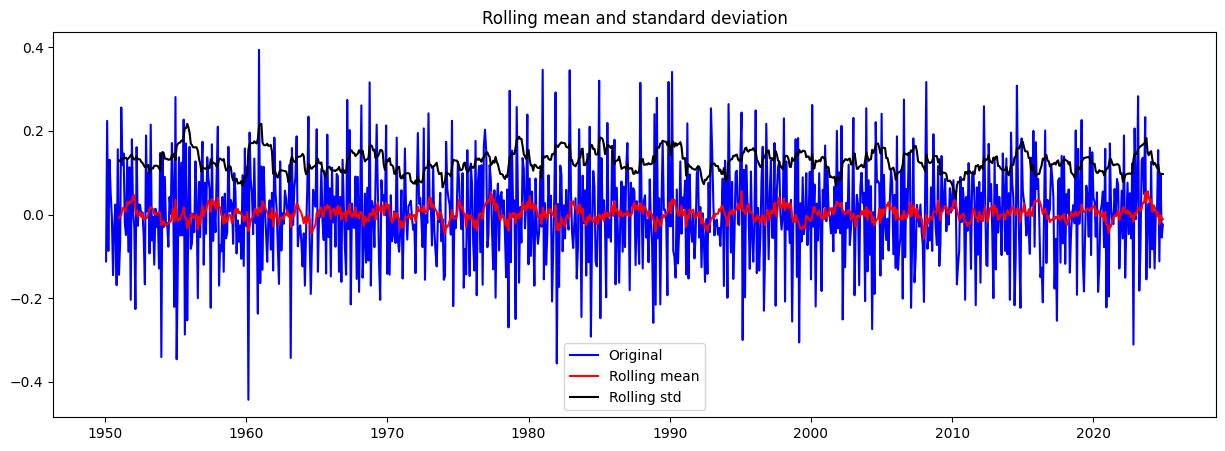

In [116]:
# What about first degree difference
diff=data.diff()
dftest(diff.Anomalies.dropna(), window=12)

Data looks stationary after 1st degree difference indicating **d=1** in ARIMA

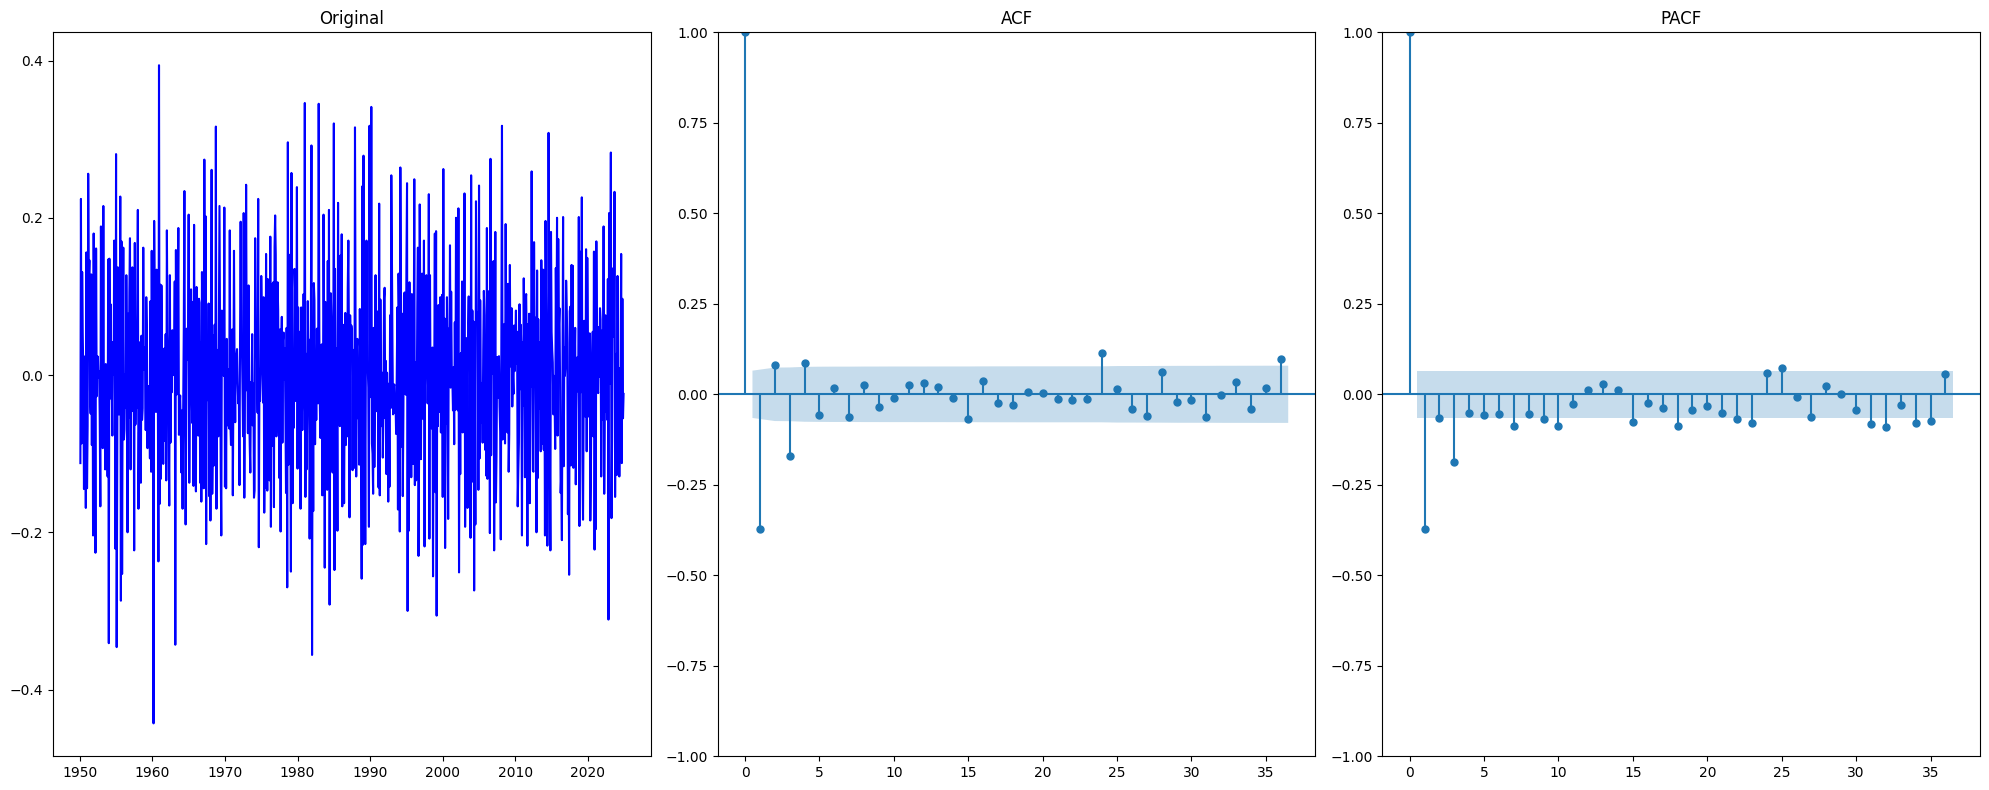

In [117]:
# Let's explore ACF and PACF of first degree difference
plots(diff.dropna(), lags=36)

It looks like **p=1 or 3, q=4 or 1, d=1**. 
Let's simulate all possibilities in ARIMA model

In [118]:
sar4=SARIMAX(data.Anomalies,
            order=(1,1,4),
            seasonal_order=(0,0,0,0),
            trend='c').fit()
sar4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Anomalies   No. Observations:                  900
Model:               SARIMAX(1, 1, 4)   Log Likelihood                 693.891
Date:                Mon, 24 Nov 2025   AIC                          -1373.781
Time:                        11:52:53   BIC                          -1340.172
Sample:                    01-01-1950   HQIC                         -1360.942
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0031      0.003      1.216      0.224      -0.002       0.008
ar.L1         -0.8350      0.186     -4.478      0.000      -1.200      -0.470
ma.L1          0.3945      0.193      2.045      0.041       0.016       0.773
ma.L2         -0.3782      0.087     -4.366      0.000      -0.548      -0.208
ma.L3         -0.2176      0.036     -6.044      0.000      -0.288      -0.147
ma.L4         -0.1285      0.061     -2.112      0.035      -0.248      -0.009
sigma2         0.0125      0.001     21.817      0.000       0.011       0.014
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.19
Prob(Q):                              0.96   Prob(JB):                         0.33
Heteroskedasticity (H):               0.97   Skew:                             0.09
Prob(H) (two-sided):                  0.79   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Poor model performance compared to our previous worst model when comparing AIC, BIC, and log likelihood**

**Excellent model diagnostics**

In [121]:
# Let's try p=1, d=1, q=1
sar5=SARIMAX(data.Anomalies,
            order=(1,1,1),
            seasonal_order=(0,0,0,0),
            trend='c').fit()
sar5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Anomalies   No. Observations:                  900
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 680.641
Date:                Mon, 24 Nov 2025   AIC                          -1353.281
Time:                        11:57:18   BIC                          -1334.076
Sample:                    01-01-1950   HQIC                         -1345.944
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.001      1.234      0.217      -0.001       0.003
ar.L1          0.3600      0.054      6.726      0.000       0.255       0.465
ma.L1         -0.7751      0.037    -21.023      0.000      -0.847      -0.703
sigma2         0.0129      0.001     21.881      0.000       0.012       0.014
===================================================================================
Ljung-Box (L1) (Q):                   2.03   Jarque-Bera (JB):                 1.01
Prob(Q):                              0.15   Prob(JB):                         0.60
Heteroskedasticity (H):               0.97   Skew:                             0.04
Prob(H) (two-sided):                  0.76   Kurtosis:                         3.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Poor performance than previous one**

In [123]:
# Let's use autoarima to find our best parameters
stepwise_model=auto_arima(data.Anomalies,
                         start_p=1, start_q=1,
                          max_p=3, max_q=4,
                         d=1, P=0, D=0, m=0, Q=0,
                         seasonal=False,
                         trace=True,
                         stepwise=True)

print(f'Best model AIC: {stepwise_model.aic()}')

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1353.281, Time=0.79 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1194.938, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1326.576, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1346.141, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1196.773, Time=0.15 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-1393.461, Time=1.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-1328.406, Time=0.28 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-1392.527, Time=1.42 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1395.747, Time=1.38 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-1349.051, Time=1.03 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-1395.930, Time=1.72 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-1383.376, Time=1.96 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-1394.901, Time=1.81 sec
 ARIMA(3,1,2)(0,0,0)[0]             : AIC=-1389.013, Time=0.82 sec

Best model:  ARIMA

In [124]:
# Let's use our best model hyperparameters
sar6=SARIMAX(data.Anomalies,
            order=(3,1,2),
            seasonal_order=(0,0,0,0),
            trend='c').fit()
sar6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              Anomalies   No. Observations:                  900
Model:               SARIMAX(3, 1, 2)   Log Likelihood                 704.965
Date:                Mon, 24 Nov 2025   AIC                          -1395.930
Time:                        12:04:03   BIC                          -1362.321
Sample:                    01-01-1950   HQIC                         -1383.090
                         - 12-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.000      3.488      0.000       0.000       0.001
ar.L1         -0.2894      0.143     -2.020      0.043      -0.570      -0.009
ar.L2          0.6534      0.071      9.206      0.000       0.514       0.792
ar.L3          0.1363      0.061      2.226      0.026       0.016       0.256
ma.L1         -0.1769      0.138     -1.280      0.201      -0.448       0.094
ma.L2         -0.7790      0.136     -5.732      0.000      -1.045      -0.513
sigma2         0.0122      0.001     21.768      0.000       0.011       0.013
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.26
Prob(Q):                              0.97   Prob(JB):                         0.53
Heteroskedasticity (H):               0.97   Skew:                             0.06
Prob(H) (two-sided):                  0.82   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

### Model interpretation and comparizon with our previous best model

#### Model Fit Statistics
- **Log Likelihood = 704.965**  
- **AIC = -1395.930**  
- **BIC = -1362.321**  
- **HQIC = -1383.090**  

Compared to SARIMAX(4,1,1):  
- (4,1,1) had **Log Likelihood = 1358.082, AIC = -2702.164, BIC = -2662.619**.  
- The (4,1,1) model was fit on a **larger dataset (2100 obs)**, while this (3,1,2) is fit on a **shorter sample (900 obs)**.  
- Direct comparison of AIC/BIC across different sample sizes isn’t strictly fair, but within its sample, (3,1,2) shows a solid fit.

---

#### Coefficients
- **Intercept = 0.0007, highly significant (p < 0.001)**.  
- **AR terms**:
  - AR(1) = -0.2894, significant (p = 0.043).  
  - AR(2) = 0.6534, strongly significant (p < 0.001).  
  - AR(3) = 0.1363, significant (p = 0.026).  
  Suggests meaningful autoregressive dependence up to lag 3.

- **MA terms**:
  - MA(1) = -0.1769, not significant (p = 0.201).  
  - MA(2) = -0.7790, strongly significant (p < 0.001).  
  The second moving average lag is important, the first is weak.

- **sigma² = 0.0122, highly significant** → residual variance is lower than in the (4,1,1) model (0.0161), suggesting tighter residuals here.

---

#### Diagnostics
- **Ljung-Box Q (lag 1) = 0.00, Prob(Q) = 0.97** → residuals show no autocorrelation (excellent).  
- **Jarque-Bera = 1.26, Prob(JB) = 0.53** → residuals are normally distributed (much better than the (4,1,1) model, which had JB = 117, p=0.00).  
- **Heteroskedasticity (H) = 0.97, Prob(H) = 0.82** → no evidence of heteroskedasticity (again, much better than (4,1,1), which had variance instability).  
- **Skew = 0.06, Kurtosis = 3.13** → residuals are nearly symmetric and close to normal distribution.

---

#### Insights
1. **Model fit**:  
   - Within its sample, SARIMAX(3,1,2) fits well, with lower residual variance and excellent diagnostics.  
   - The (4,1,1) model had slightly better AIC/BIC on the larger dataset, but diagnostics showed non-normality and heteroskedasticity.

2. **Interpretation**:  
   - (3,1,2) captures dynamics with AR lags 1–3 and a strong MA(2).  
   - (4,1,1) relied on AR lags 1,2,4 and a strong MA(1).  
   - Both models emphasize short-term dependence, but (3,1,2) balances AR and MA terms differently.

3. **Diagnostics comparison**:  
   - (3,1,2) residuals are **cleaner** (normal, homoskedastic, no autocorrelation).  
   - (4,1,1) residuals had heavy tails and heteroskedasticity.  
   - This makes (3,1,2) more statistically robust, even if its AIC is slightly higher relative to sample size.


looks like we found our new best model `SARIMAX(3,1,2)`

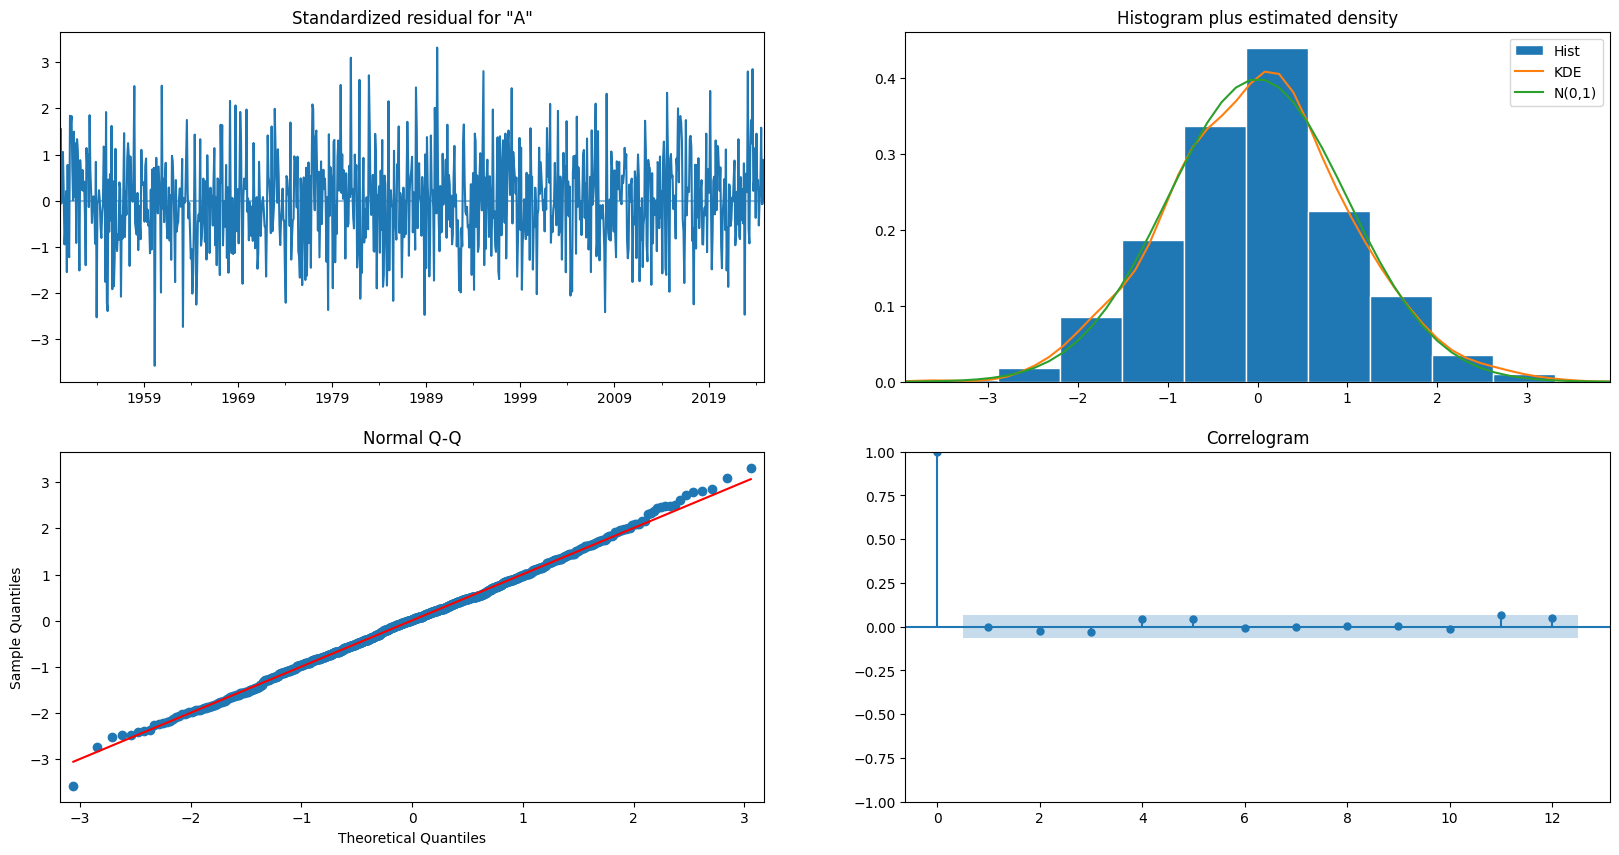

In [125]:
# You can check model diagnostic visually
sar6.plot_diagnostics(lags=12, figsize=(20,10));

Very well, compared to our previous model

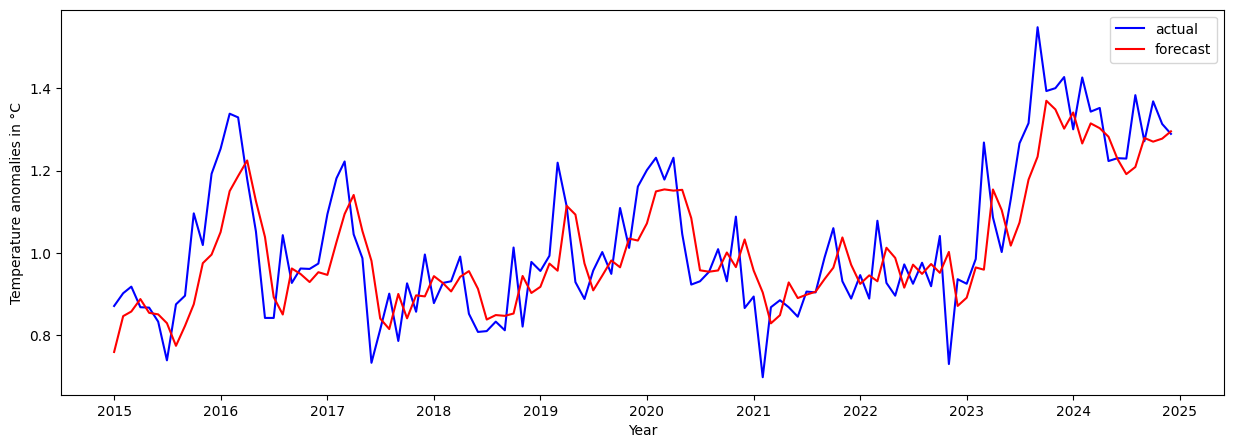

In [128]:
# Now let's visualize the forecast in previous 10 years
data['forecast']=sar6.predict(start=780, end=900)
plt.figure(figsize=(15,5))
plt.plot(data.Anomalies[780:], 'b-', label='actual')
plt.plot(data.forecast[780:], 'r-', label='forecast')
plt.xlabel('Year')
plt.ylabel('Temperature anomalies in °C')
plt.legend()
plt.show()

This forecast also looks great in terms of capturing trends and patterns

**Now, let's use our best model to predict the situation in 2050 and 2100**

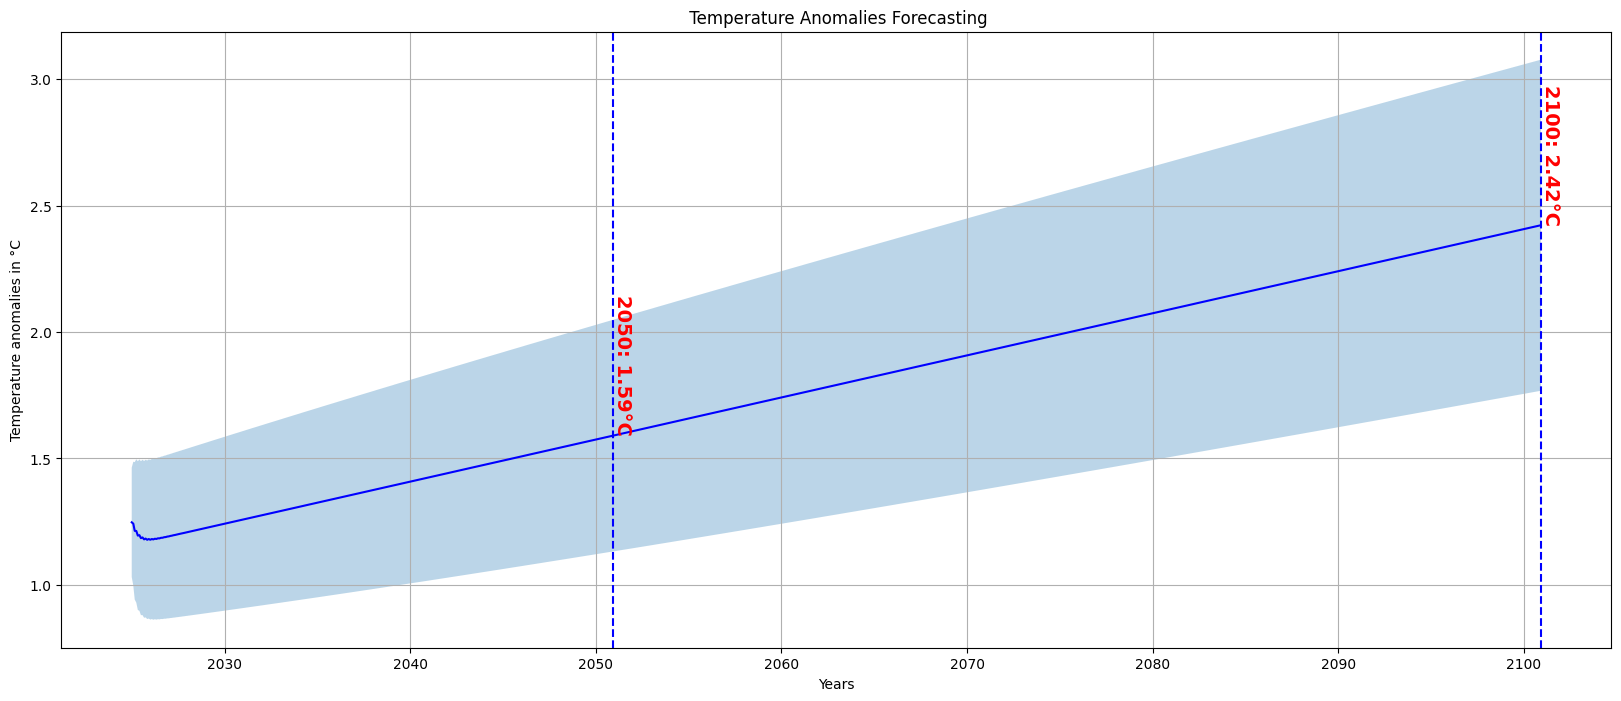

In [143]:
# Predicting next 100 years (1200 months)
model=SARIMAX(data.Anomalies,
                  order=(3,1,2),
                  seasonal_order=(0,0,0,0),
                  trend='c').fit()

def future_preds_df(model, series, num_months):
    from dateutil.relativedelta import relativedelta
    import pandas as pd
    
    # Create future date index
    pred_first = series.index.max() + relativedelta(months=1)
    pred_last = series.index.max() + relativedelta(months=num_months)
    date_range_index = pd.date_range(pred_first, pred_last, freq='MS')
    
    # Get forecast and confidence intervals
    forecast = model.get_forecast(steps=num_months)
    CI = forecast.conf_int(alpha=0.05)
    
    return pd.DataFrame({
        'forecast': forecast.predicted_mean.values,
        'lower_CI': CI.iloc[:,0].values,
        'upper_CI': CI.iloc[:,1].values
    }, index=date_range_index)

# Predictions
prediction2=future_preds_df(model=model, series=data.Anomalies, num_months=912)

# Plot predictions
plt.figure(figsize=(20,8))
plt.plot(prediction2.forecast, 'b-', label='forecast')
plt.fill_between(prediction2.index, prediction2.lower_CI, prediction2.upper_CI, alpha=0.3)

# Add vertical line indicating value for 2050 and 2100

val_2050 = prediction2.loc["2050-12-01"]
val_2100 = prediction2.loc["2100-12-01"]

# If they are Series, take the first element
val_2050 = float(val_2050.values[0]) if hasattr(val_2050, "values") else float(val_2050)
val_2100 = float(val_2100.values[0]) if hasattr(val_2100, "values") else float(val_2100)

plt.axvline(pd.to_datetime("2050-12-01"), color='blue', linestyle='--', label='2050')
plt.axvline(pd.to_datetime("2100-12-01"), color='blue', linestyle='--', label='2100')

plt.text(pd.to_datetime("2050-12-01"), val_2050,
         f"2050: {val_2050:.2f}°C",
         rotation=270, va='bottom', ha='left', color='red', fontsize=14, fontweight='bold')

plt.text(pd.to_datetime("2100-12-01"), val_2100,
         f"2100: {val_2100:.2f}°C",
         rotation=270, va='bottom', ha='left', color='red', fontsize=14, fontweight='bold')

plt.xlabel('Years')
plt.ylabel('Temperature anomalies in °C')
plt.title(' Temperature Anomalies Forecasting')
plt.xticks
plt.grid()
plt.show()

We can see that this model provide very high confidence compared to previous model (SARIMAX(4,1,1))

In [133]:
print(data_annual.head())

            Anomalies
1850-01-01  -0.435667
1851-01-01  -0.320750
1852-01-01  -0.292250
1853-01-01  -0.294500
1854-01-01  -0.283333


In [146]:
# Forecast resampled in years
prediction2_annual=prediction2.resample('YS').mean()
print(f'In 2050, temp: {prediction2_annual.loc["2050-01-01"]}\n')
print(f'In 2100, temp: {prediction2_annual.loc["2100-01-01"]}\n')
print(f'In 2025, temp: {prediction2_annual.loc["2025-01-01"]}')

In 2050, temp: forecast    1.582260
lower_CI    1.126376
upper_CI    2.038145
Name: 2050-01-01 00:00:00, dtype: float64

In 2100, temp: forecast    2.414817
lower_CI    1.761547
upper_CI    3.068087
Name: 2100-01-01 00:00:00, dtype: float64

In 2025, temp: forecast    1.200092
lower_CI    0.910710
upper_CI    1.489475
Name: 2025-01-01 00:00:00, dtype: float64


# Prediction using Facebook prophet

For `Prophet` model, we need our time data to be in column called `ds` and our variable of interest as `y`. Therefore we will need to reshape our dataset. We will begin with full dataset from 1850 and then after we will try from 1950 and compare which model performed very well

In [150]:
data_full.head()

,Anomalies
1850-01-01,-0.753
1850-02-01,-0.202
1850-03-01,-0.367
1850-04-01,-0.596
1850-05-01,-0.619


In [157]:
# Create colum 'ds' with date the data were recorded
data_prophet=data_full
data_prophet['ds']=data_full.index

# Replace column 'Anomalies' with 'y'
data_prophet=data_prophet.rename(columns={'Anomalies':'y'})
data_prophet.head()

,y,ds
1850-01-01,-0.753,1850-01-01
1850-02-01,-0.202,1850-02-01
1850-03-01,-0.367,1850-03-01
1850-04-01,-0.596,1850-04-01
1850-05-01,-0.619,1850-05-01


In [160]:
# Let's define our model
m=Prophet()

# Fit our model
m.fit(data_prophet)

# Create an empty DataFrame to store our prediction
future=m.make_future_dataframe(periods=912, freq='MS')

# Let's check our prediction dataframe
print(future.head())
print(future.tail())

21:40:08 - cmdstanpy - INFO - Chain [1] start processing
21:40:09 - cmdstanpy - INFO - Chain [1] done processing


          ds
0 1850-01-01
1 1850-02-01
2 1850-03-01
3 1850-04-01
4 1850-05-01
             ds
3007 2100-08-01
3008 2100-09-01
3009 2100-10-01
3010 2100-11-01
3011 2100-12-01


In [162]:
# Now, let's do forecasting
forecast=m.predict(future)
print(forecast.columns)

# Show last 5 values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'yearly', 'yearly_lower', 'yearly_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'yhat'],
      dtype='object')


,ds,yhat,yhat_lower,yhat_upper
3007,2100-08-01,2.668860,2.179502,3.145758
3008,2100-09-01,2.664424,2.198396,3.140272
3009,2100-10-01,2.699427,2.221002,3.186042
3010,2100-11-01,2.630070,2.134226,3.134581
3011,2100-12-01,2.661619,2.186328,3.135461


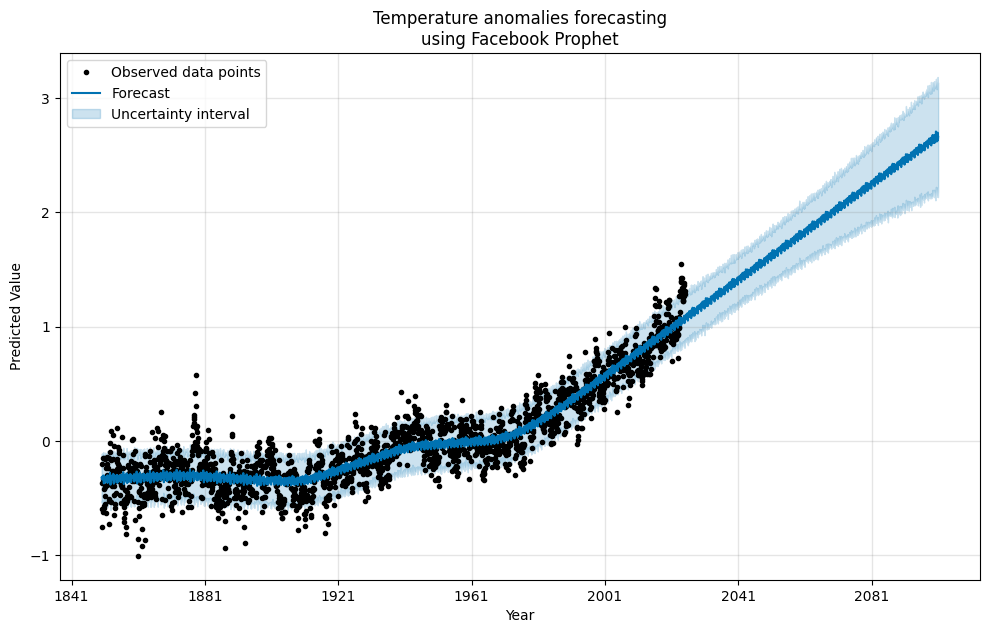

In [164]:
# Let's visualize the whole prediction
fig = m.plot(forecast)   # Prophet forecast plot
ax = fig.gca()           # get current Axes from the figure

ax.set_xlabel("Year")    # custom x-axis label
ax.set_ylabel("Predicted Value")  # custom y-axis label
ax.set_title('Temperature anomalies forecasting\nusing Facebook Prophet')
ax.legend()
plt.show()

This model fits well the data and is able to capture trends

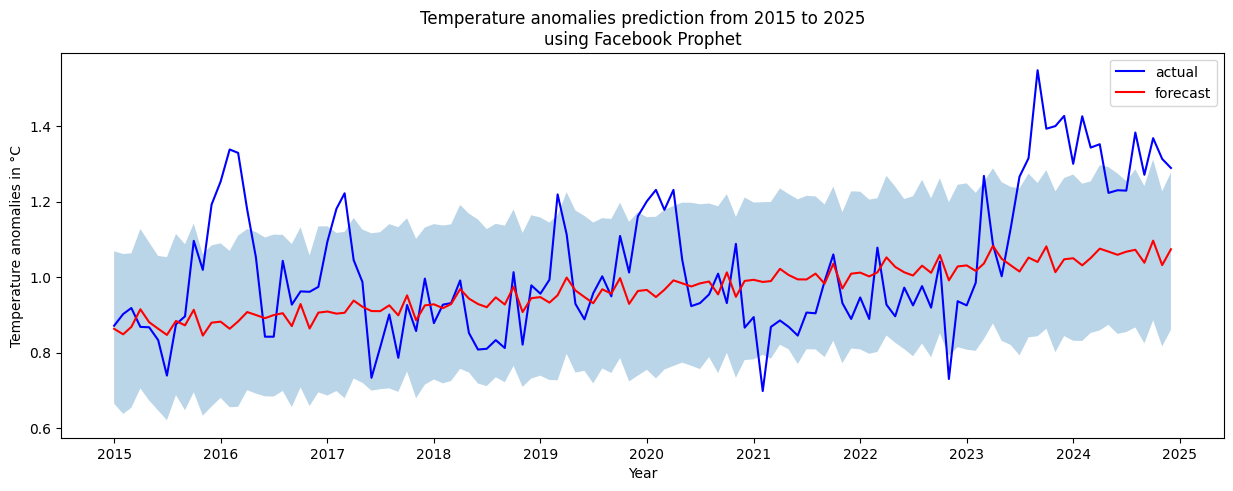

In [170]:
# Let's try to visualize previous 10 years
previous10_forec=forecast[(forecast['ds']>='2015-01-01') & (forecast['ds']<='2024-12-01')]
previous10_act=data_prophet[(data_prophet['ds']>='2015-01-01')  & (data_prophet['ds']<='2024-12-01')]

plt.figure(figsize=(15,5))
plt.plot(previous10_act.ds, previous10_act.y, 'b-', label='actual')
plt.plot(previous10_forec.ds, previous10_forec.yhat, 'r-', label='forecast')
plt.fill_between(previous10_forec.ds, previous10_forec.yhat_lower, previous10_forec.yhat_upper, alpha=0.3)
plt.xlabel('Year')
plt.ylabel('Temperature anomalies in °C')
plt.title('Temperature anomalies prediction from 2015 to 2025\nusing Facebook Prophet')
plt.legend()
plt.show()

We can see that the model picked overall trend. However, failed to learn about patterns change, probably because they are random noise

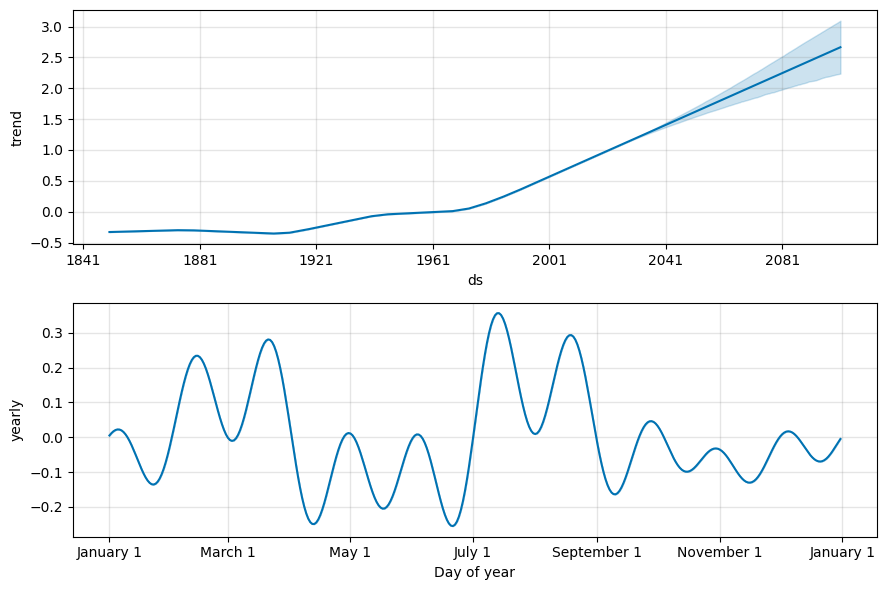

In [171]:
# Let's visualize model forecast components
m.plot_components(forecast);

The above graphs shows that the temperature anomalies were almost constant to around 1910, and were below 0. from 1950 to around 1970, there was slow increase in anomalies and reached 0. However, after that, the temperature anomalies have been increasing over time and is expected to reach above 2.5 °C in 2100.

The monthly analysis shows that temperature anomalies is higher between februally-april and july-september probably because of winter and spring period

## Model evaluation and comparison

Since our previous best model was SARIMAX(3,1,2) which we fitted to data from 1950, we are going to fit the data and keep 15 years (20%) of our dataset for testing their accuracy. 

We will fit both SARIMAX and Prophet model and evaluate their performance using RMSE, and MAE along with ACF and PACF plots

In [179]:
# Define training and testing set
data=data_prophet['1950-01-01':]
train=data[:-180]
test=data[-180:]

# Fitting SARIMAX
model=SARIMAX(train.y, order=(3,1,2), seasonal_order=(0,0,0,0), trend='c').fit()
sarima_preds=model.get_forecast(steps=len(test)).predicted_mean

# Fitting Facebook Prophet
m=Prophet()
m.fit(train)
future=m.make_future_dataframe(periods=len(train), freq='MS')
forecast=m.predict(future)
prophet_preds=forecast.loc[forecast['ds'].isin(test['ds']), ['ds','yhat']]
prophet_preds=prophet_preds.set_index('ds')

22:54:27 - cmdstanpy - INFO - Chain [1] start processing
22:54:28 - cmdstanpy - INFO - Chain [1] done processing


In [182]:
# Let's build dataframe containing actual test value, sarima_preds, and prophet_preds
data_comp=pd.DataFrame({'actual': test.y, 'sarima_preds': sarima_preds.values, 'prophet_preds':prophet_preds.yhat}, index=test.ds)
data_comp.head()

,actual,sarima_preds,prophet_preds
ds,,,
2010-01-01,0.837,0.769947,0.755642
2010-02-01,0.919,0.752851,0.747477
2010-03-01,0.934,0.745861,0.733119
2010-04-01,0.989,0.734129,0.775680
2010-05-01,0.822,0.731607,0.748079


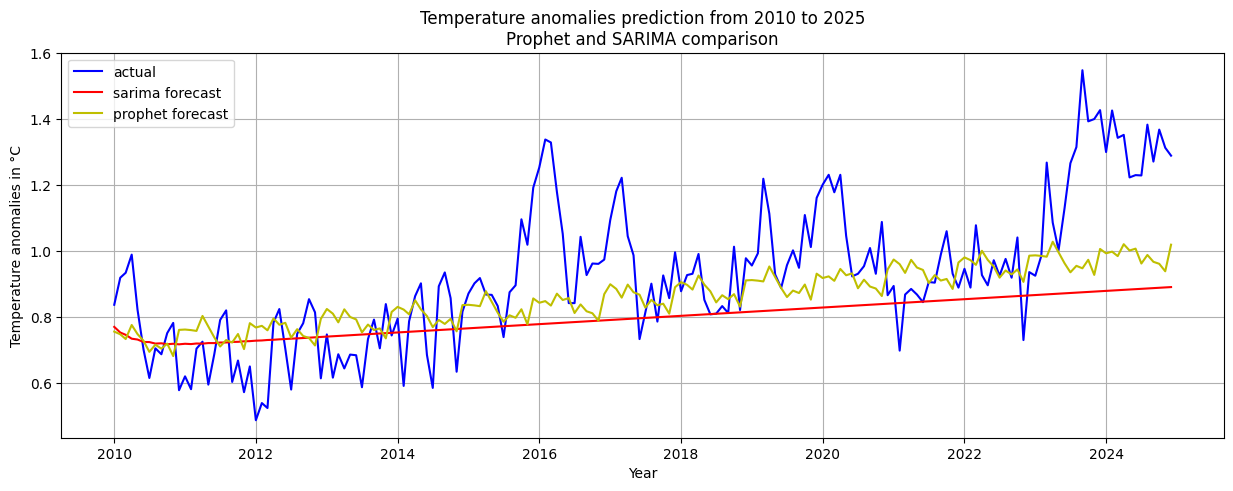

In [183]:
# Let's visualize the results of models
plt.figure(figsize=(15,5))
plt.plot(data_comp.index, data_comp.actual, 'b-', label='actual')
plt.plot(data_comp.index, data_comp.sarima_preds, 'r-', label='sarima forecast')
plt.plot(data_comp.index, data_comp.prophet_preds, 'y-', label='prophet forecast')
plt.xlabel('Year')
plt.ylabel('Temperature anomalies in °C')
plt.title('Temperature anomalies prediction from 2010 to 2025\nProphet and SARIMA comparison')
plt.grid()
plt.legend()
plt.show()

Using visualization, we can actually see that Prophet performed very well in capturing patterns even trends.

However, let's use metrics to assess this hypothesis

In [190]:
# Assess the performance of our models on testing set
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# Prophet diagnostic metrics
mae_prophet=mean_absolute_error(test.y, data_comp.prophet_preds)
rmse_prophet=root_mean_squared_error(test.y, data_comp.prophet_preds)

# SARIMA diagnostic metrics
mae_sarima=mean_absolute_error(test.y, data_comp.sarima_preds)
rmse_sarima=root_mean_squared_error(test.y, data_comp.sarima_preds)

# Print results
print(f'MAE for Prophet model: {mae_prophet:.3f}')
print(f'MAE for SARIMAX model: {mae_sarima:.3f}')
print(f'RMSE for Prophet model: {rmse_prophet:.3f}')
print(f'RMSE for SARIMAX model: {rmse_sarima:.3f}')

MAE for Prophet model: 0.138
MAE for SARIMAX model: 0.168
RMSE for Prophet model: 0.183
RMSE for SARIMAX model: 0.223


### Comparison interppretation

- **MAE**: On average, Prophet’s predictions are off by about **0.138 units**, while SARIMAX’s are off by **0.168 units**.  
  → Prophet is closer to the actual values on average.

- **RMSE**: Prophet’s RMSE is **0.183**, SARIMAX’s is **0.223**.  
  → RMSE penalizes larger errors more strongly, so this shows Prophet not only has smaller average errors but also fewer large deviations compared to SARIMAX.

### Overall interpretation
- **Prophet outperformed SARIMAX** on both metrics in your test set.  
- Prophet’s forecasts are more accurate and stable, capturing the underlying trend/patterns better.  
- SARIMAX still provides reasonable forecasts, but its errors are larger and more variable.  
- The difference is modest, but consistent across both MAE and RMSE, which strengthens the conclusion.

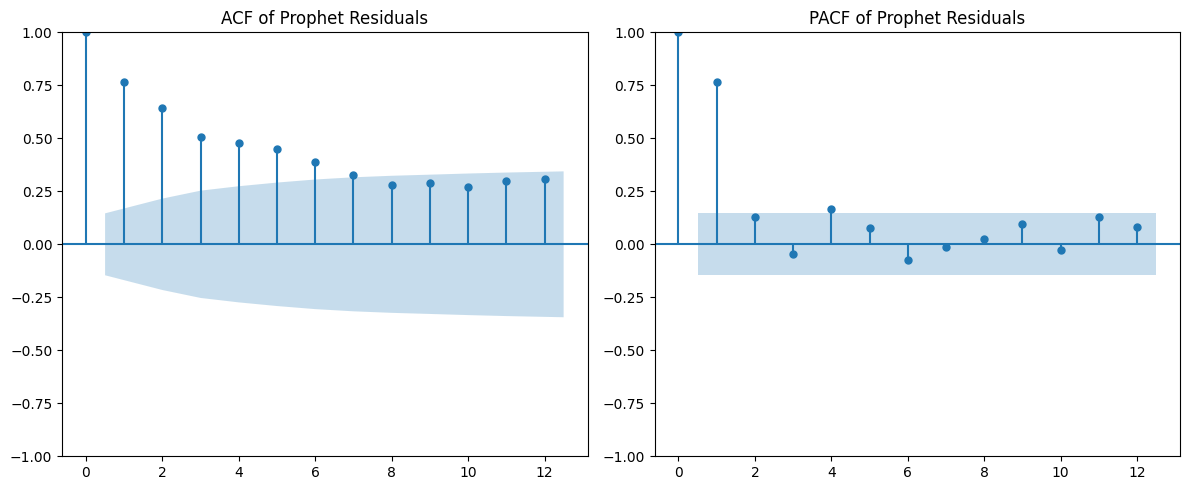

In [193]:
# Lets check if there is any autocorrelation of residuals for Prophet
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Calculate residuals
residuals = test['y'].values - data_comp['prophet_preds'].values

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF on the first subplot
plot_acf(residuals, lags=12, ax=axes[0])
axes[0].set_title("ACF of Prophet Residuals")

# Plot PACF on the second subplot
plot_pacf(residuals, lags=12, ax=axes[1])
axes[1].set_title("PACF of Prophet Residuals")

plt.tight_layout()
plt.show()

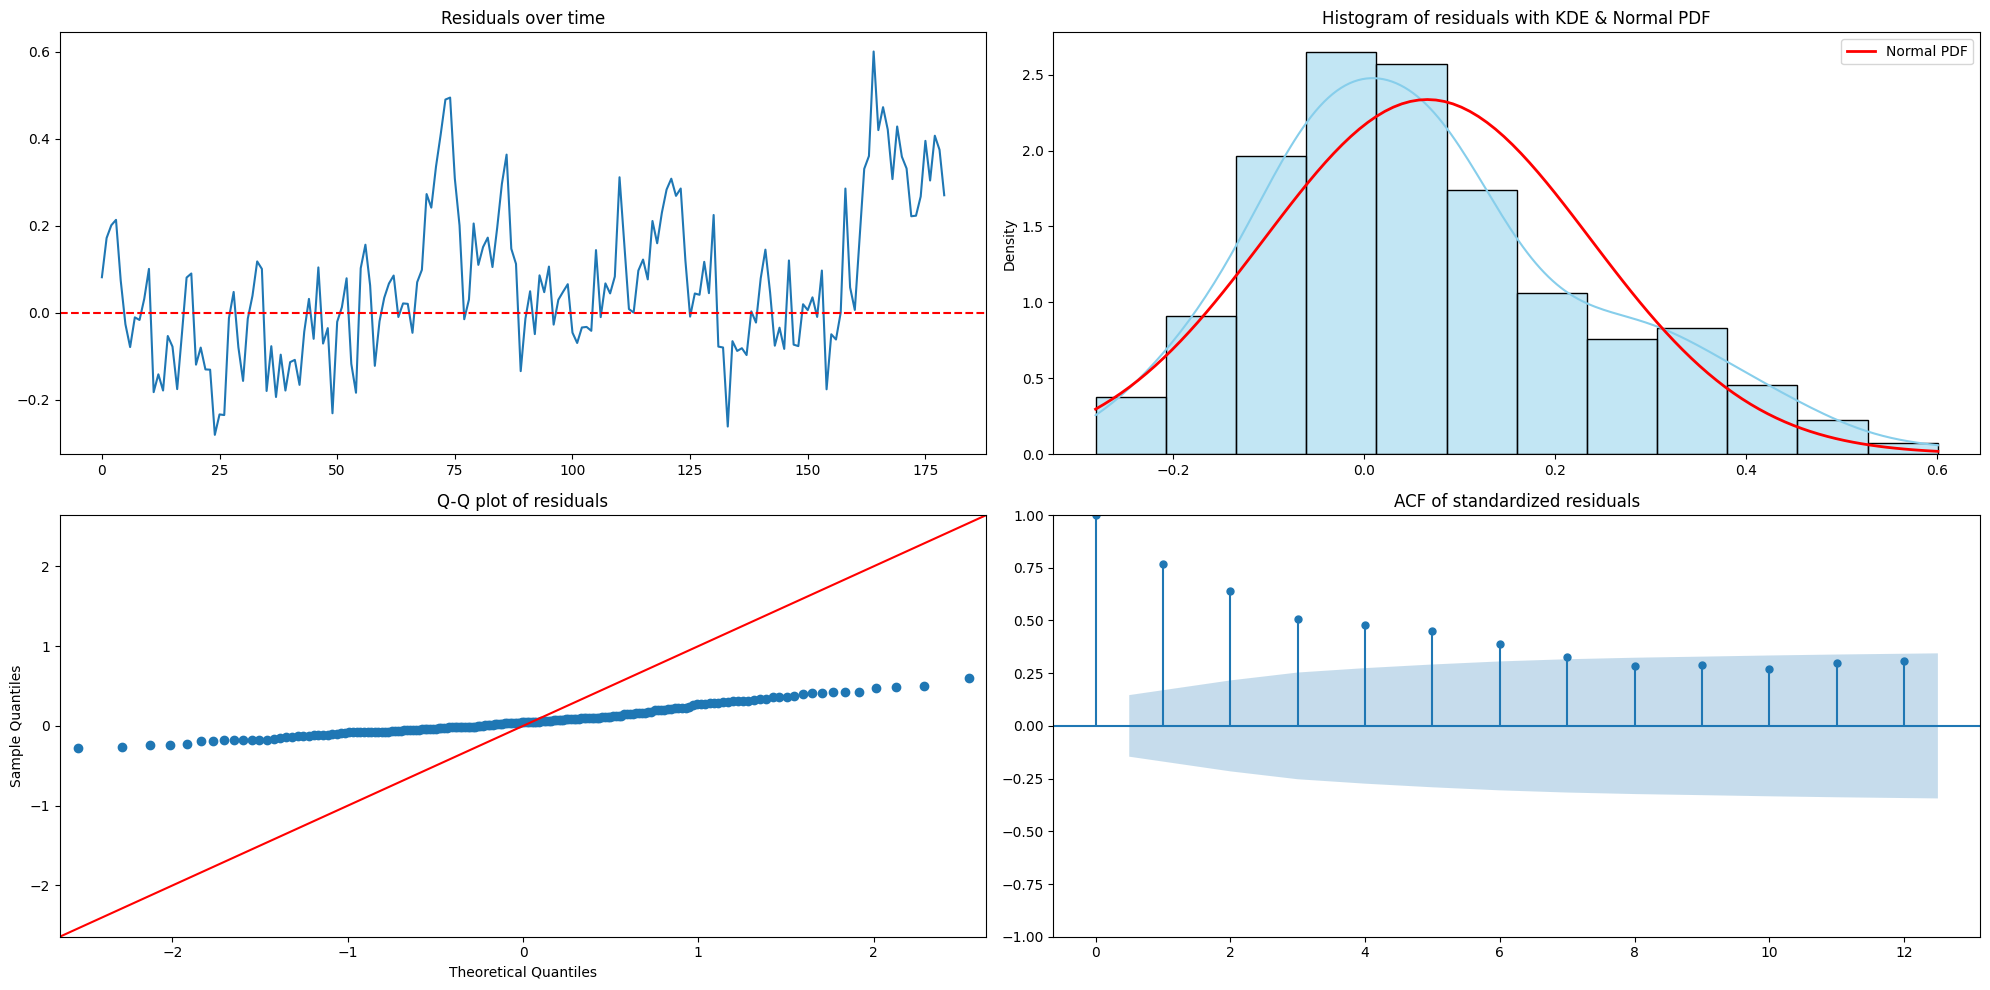

In [195]:
# Let's diagnose our Prophet model before making final decision

# define residuals
residuals = test['y'].values - data_comp['prophet_preds'].values

# Standardize residuals
resid_std = (residuals - np.mean(residuals)) / np.std(residuals)

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

# 1. Residuals over time
axes[0,0].plot(residuals)
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_title("Residuals over time")

# 2. Histogram + KDE + Normal curve
sns.histplot(residuals, kde=True, stat="density", ax=axes[0,1], color="skyblue")
# Overlay normal distribution line
x_vals = np.linspace(min(residuals), max(residuals), 100)
axes[0,1].plot(x_vals, 
               1/(np.std(residuals)*np.sqrt(2*np.pi)) * 
               np.exp(-(x_vals-np.mean(residuals))**2/(2*np.std(residuals)**2)),
               color='red', lw=2, label="Normal PDF")
axes[0,1].set_title("Histogram of residuals with KDE & Normal PDF")
axes[0,1].legend()

# 3. Q-Q plot
sm.qqplot(residuals, line='45', ax=axes[1,0])
axes[1,0].set_title("Q-Q plot of residuals")

# 4. ACF of standardized residuals
plot_acf(resid_std, lags=12, ax=axes[1,1])
axes[1,1].set_title("ACF of standardized residuals")

plt.tight_layout()
plt.show()

We can see that our standardized residuals are not not normally distributed, have right tail, and have very strong autocolleration.

**This is a red fla** 
- ACF plot shows significant autocorrelation in Prophet residuals.
- This means Prophet is missing short-term dependencies which can compound over time, leading to biased long-term forecasts.
- If residuals are not normal → prediction intervals may be unreliable.

**Therefore, though Prophet showed not only smaller average errors but also fewer large deviations compared to SARIMAX, it violated principal assumption that residuals must be random residuals, thus its forecast could be biased. For this reason, predictions done by SARIMAX will hold**

## Conclusion

**The prediction from SARIMA (3,1,2) indicates that**:

* It is expected that by middle of 21st century will rise to **2.02 °C +/- 0.91** compared to temperature in 1850 before preindustrial era. 

* It is also estimated that by the end of 21st century, the rise of temperature will be **2.85 °C +/- 1.31** compared to temperature in 1850 before preindustrial era

* In 2025, we are on **1.64 °C +/- 0.58** and we have already surpassed 1.5 °C

* This indicates that there is too much efforts needed to fullfil the objective of Paris Agreement of limiting global temperature to below 2 °C and better at 1.5 °C above pre-industrial era. This will require collaboration and compromise for all countries to reduce carbon emission and go beyond achieving net-zero carbon emission. 